# Прогнозирование ВВП Ганы

## Библиотеки

In [1]:
import itertools
import numpy as np
import pandas as pd

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import pipeline
from pmdarima import preprocessing
import pmdarima as pm

from arch import arch_model

from sklearn import model_selection

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("dark")

import warnings
# warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML

## Входные данные

In [2]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col = ["year"])
data.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Переименовали колонку `'GDP (current US$)'` в `'GDP'` для удобства.

## Графика

In [3]:
def plot_line(data: pd.DataFrame, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sns.lineplot(data=data, ax=ax)
    plt.show()


def plot_moving_average(data: pd.DataFrame,
                        column_name: str,
                        column_title: str, column_label: str,
                        smoothed_title: str, smoothed_label: str,
                        start_window: int, windows_delta: int, number_of_windows: int,
                        size_inches: tuple):
    fig, ax = plt.subplots(number_of_windows, 2)
    # fig.tight_layout(pad=2.0)
    plt.subplots_adjust(top=1.6, wspace=0.1)
    fig.set_size_inches(*size_inches)

    figure_index = 0
    for window in np.arange(start_window, start_window + number_of_windows * windows_delta, windows_delta):
        ax[figure_index, 0].plot(data[column_name], color="blue", label=column_label)
        ax[figure_index, 0].set_title(column_title, size=10)
        ax[figure_index, 0].legend()

        ax[figure_index, 1].plot(data[column_name].rolling(window=window).mean(),
                                color="orange", label=smoothed_label)
        ax[figure_index, 1].plot(data[column_name].rolling(window=window).std(),
                                color="red", label='Rolling Std. Dev.')
        ax[figure_index, 1].set_title(
            f"Moving Average (window size: {window}) - {smoothed_title}", size=10)
        ax[figure_index, 1].legend()

        figure_index = figure_index + 1

    plt.show()


def plot_seasonal_decompose(data, model: str, size_inches: tuple):
    result = seasonal_decompose(data, model=model)
    fig = result.plot()
    fig.set_size_inches(*size_inches)
    fig.tight_layout(h_pad=0.0, w_pad=0.0)
    plt.show()
    return result

### График исходного временного ряда

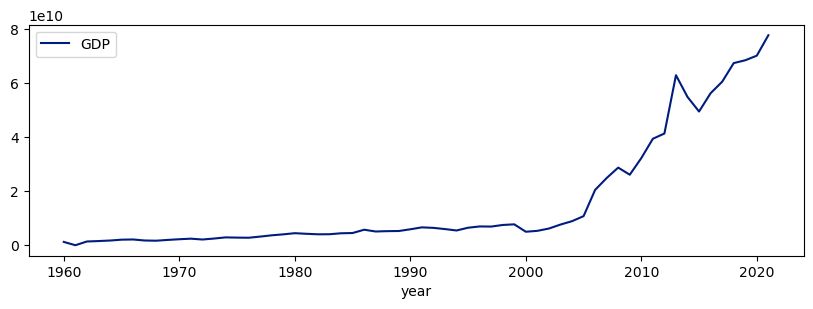

In [4]:
plot_line(data=data, size_inches=(10, 3))

Интересен резкий рос ВВП c 2005-го года по 2006 год на 90%.

### График логарифма исходного временного ряда

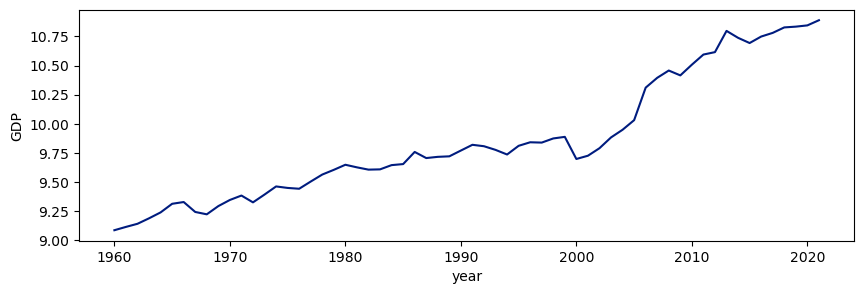

In [5]:
plot_line(data=np.log10(data['GDP'].replace(0, np.nan).interpolate(method='linear')), size_inches=(10, 3))

## Разделение на тренировочную и тестовую выборки

In [6]:
train_data = data.loc[:"2018-12-31"]
test_data = data.loc["2019-01-01":]
train_data.shape, test_data.shape

((59, 1), (3, 1))

## Скользящие средние

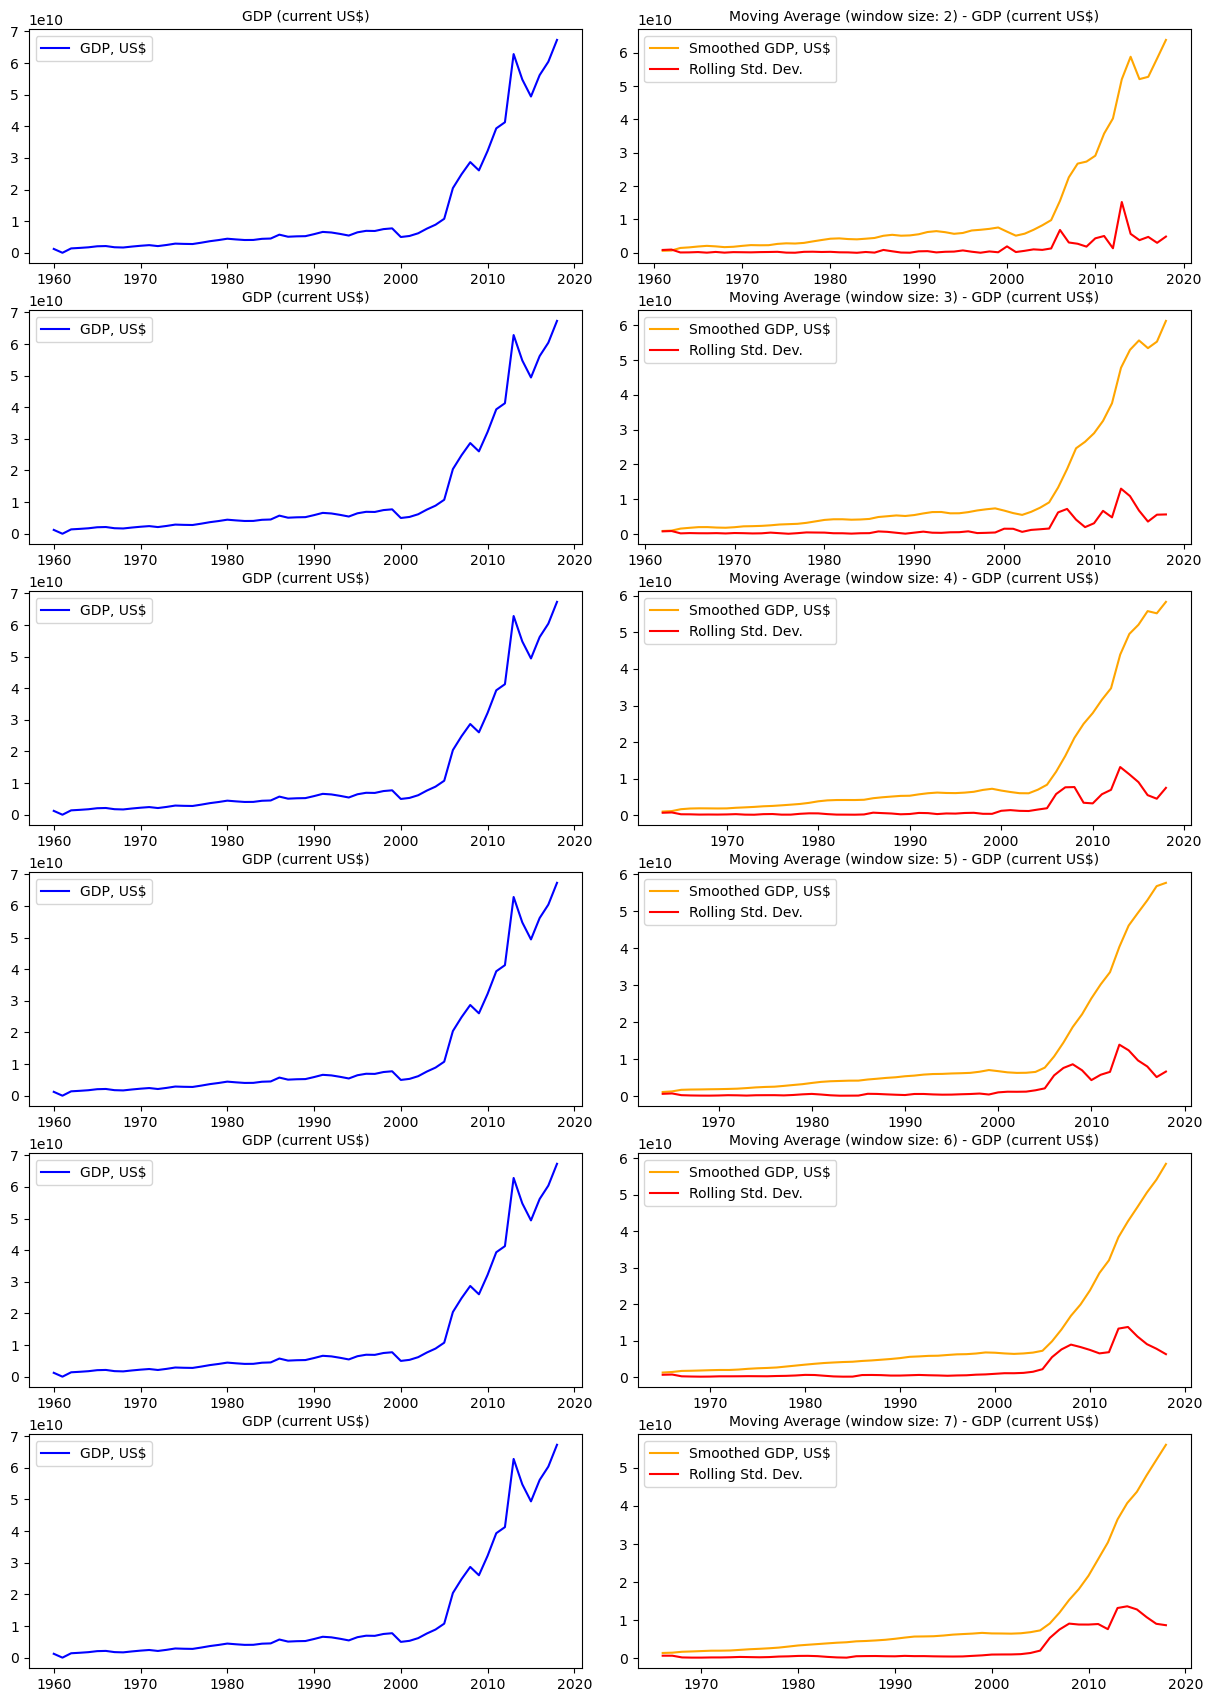

In [7]:
plot_moving_average(data=train_data,
                    column_name='GDP',
                    column_title='GDP (current US$)', column_label='GDP, US$',
                    smoothed_title='GDP (current US$)', smoothed_label='Smoothed GDP, US$',
                    start_window=2, windows_delta=1, number_of_windows=6,
                    size_inches=(15, 11))


## Декомпозиция на тренд и сезонность

### Аддитивная сезонность

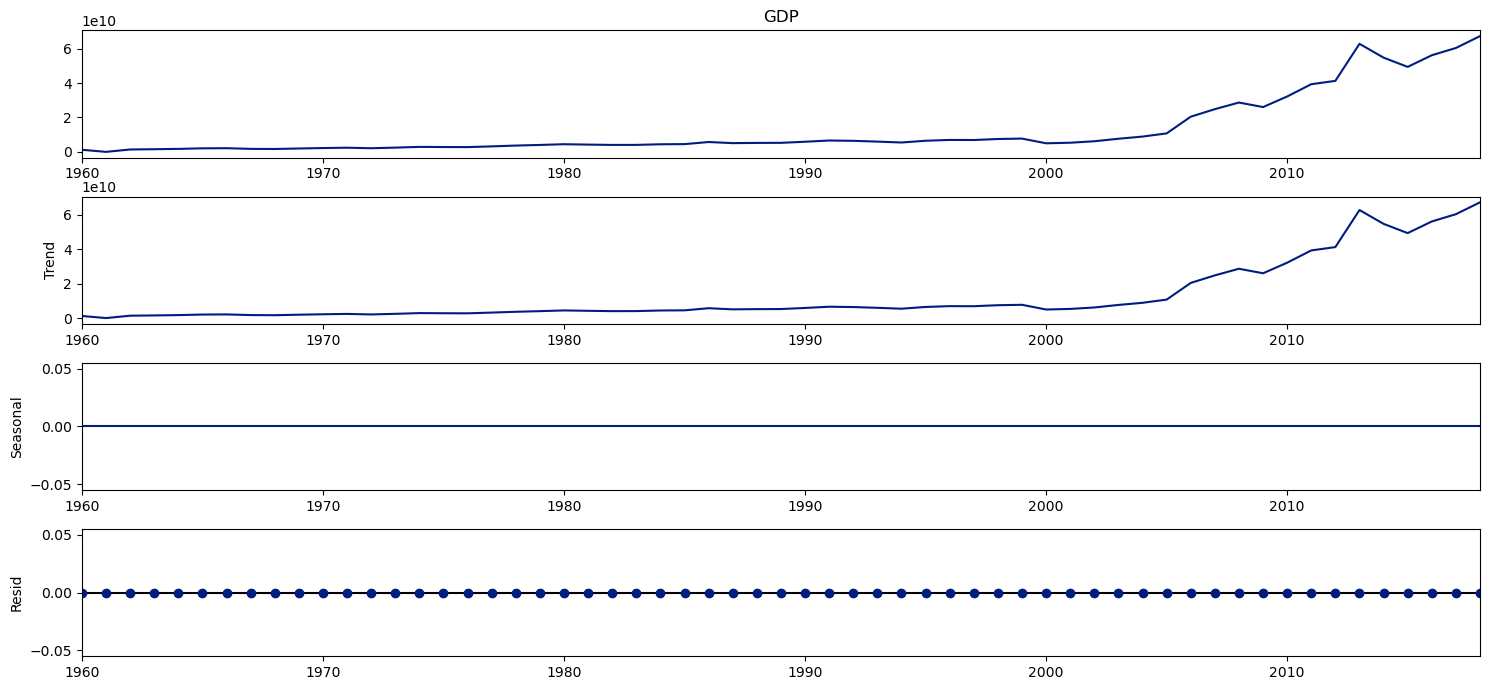

In [8]:
seasonal_decompose_result = plot_seasonal_decompose(
    data=train_data['GDP'].interpolate(method='linear'),
    model='additive',
    size_inches=(15, 7)
)

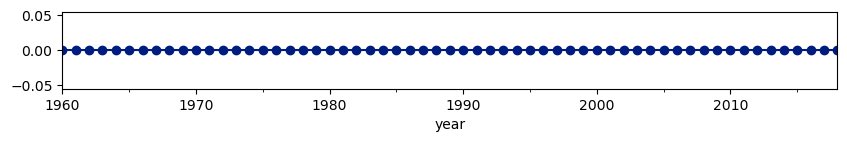

In [9]:
plt.rcParams["figure.figsize"] = 10, 1
seasonal_decompose_result.seasonal[:60].plot(marker="o")
plt.show()

Сезонность по наивной модели декомпозиции отсутствует.

## Стационарность ряда GDP

### Кореллограммы

In [10]:
def plot_acf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, zero=True, lags=lags, ax=ax)
    plt.show()


def plot_pacf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_pacf(data, zero=True, lags=lags, method='ywm', ax=ax)
    plt.show()


def plot_acf_pacf(data, acf_lags: int, pacf_lags: int, size_inches: tuple):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, lags=acf_lags, ax=axes[0])
    sgt.plot_pacf(data, lags=pacf_lags, method='ywm', ax=axes[1])
    plt.show()


#### Автокорреляция

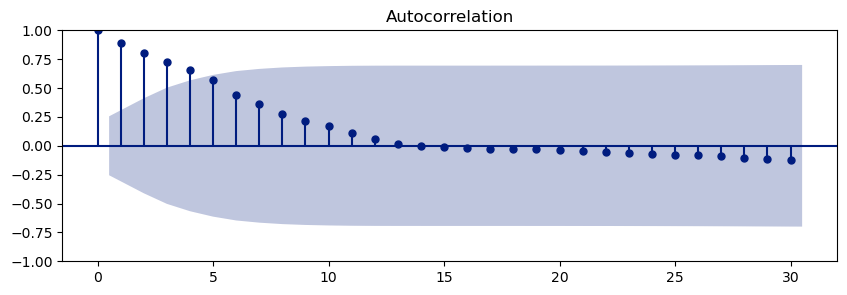

In [11]:
plot_acf(data=train_data['GDP'], lags=30, size_inches=(10, 3))

До 15-го лага имеется положительная автокорреляция. Затем она постепенно становится отрицательной, но незначительно<br>
Значительная автокорреляция сохраняется для 3-4 лагов (годов).
Положим q = 3.

In [12]:
q = 3

#### Частичная автокорреляция

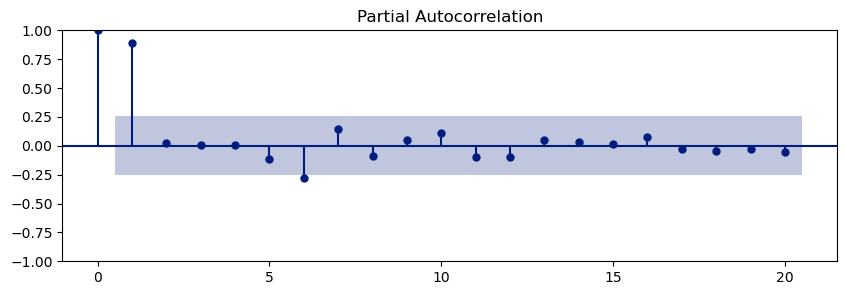

In [13]:
plot_pacf(data=train_data['GDP'], lags=20, size_inches=(10, 3))

Порядок возможной авторегрессионной модели - 1. Положим p = 1.

In [14]:
p = 1

#### Тест Дики-Фуллера

In [15]:
def test_dickey_fuller(data, maxlag: int = 10, regression: str = 'c'):
    result = adfuller(data, maxlag=maxlag)
    print(f'adf: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('used lag: ', result[2])
    print('Critical values: ', result[4])
    print('----------')
    if result[0] > result[4]['5%']:
        print(f"Ряд нестационарен: статистика теста {result[0]:.3f} больше критического значения \
{result[4]['5%']:.3f} для уровня значимости 5%.")
    else:
        print('Ряд стационарен')

##### Тест изначального ряда

In [16]:
test_dickey_fuller(train_data, maxlag=20)

adf: 2.166
p-value: 0.999
used lag:  16
Critical values:  {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
----------
Ряд нестационарен: статистика теста 2.166 больше критического значения -2.933 для уровня значимости 5%.


- Статистика теста Дики-Фуллера значительно выше всех критических значений.
- Графики скользящих средних значительно выше соответствующих графиков стандартных отклонений и возрастают со временем.
- Стандартное отклонение (дисперсия) непостоянна.

<i>Положительная аддитивная модель роста</i><br>
<b>Ряд нестационарен</b>

### Коррелограммы дифференцированных рядов и их распределения

In [17]:
def plot_acf_pacf_derivative(data, derivative_order: int):
    d_data = data

    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()

    plot_acf_pacf(
        d_data,
        acf_lags=20, pacf_lags=20,
        size_inches=(15, 3)
    )
        
    return d_data


def plot_pdf_derivative(data, derivative_order: int):
    d_data = data

    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 1.5)
    sns.histplot(data=d_data, kde=True, ax=ax)
    sns.rugplot(data=d_data, ax=ax)
    plt.show()


def time_series_derivative(data, derivative_order: int):
    d_data = data
    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()
    return d_data

#### Дифференцирование 1-го порядка

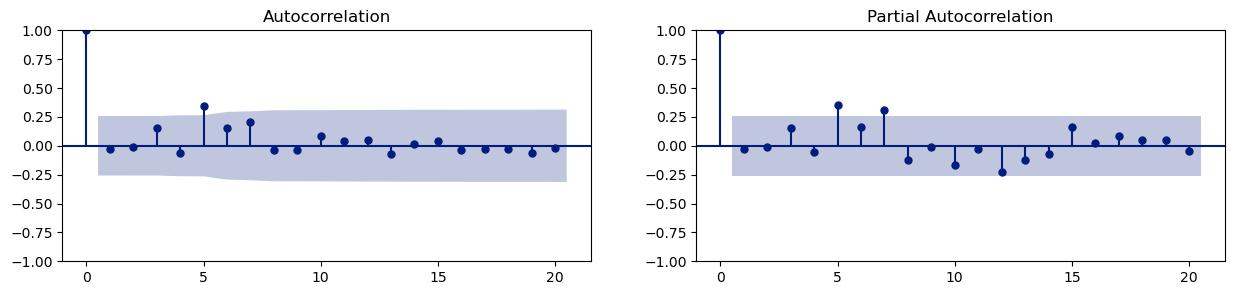

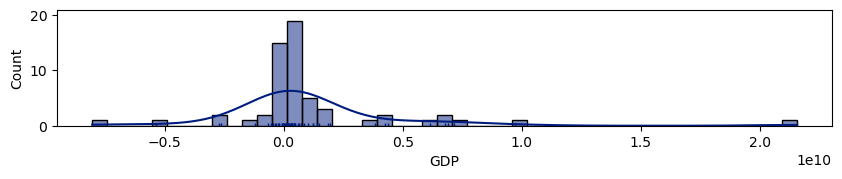

In [18]:
plot_acf_pacf_derivative(train_data['GDP'], 1)
plot_pdf_derivative(train_data['GDP'], 1)

#### Дифференцирование 2-го порядка

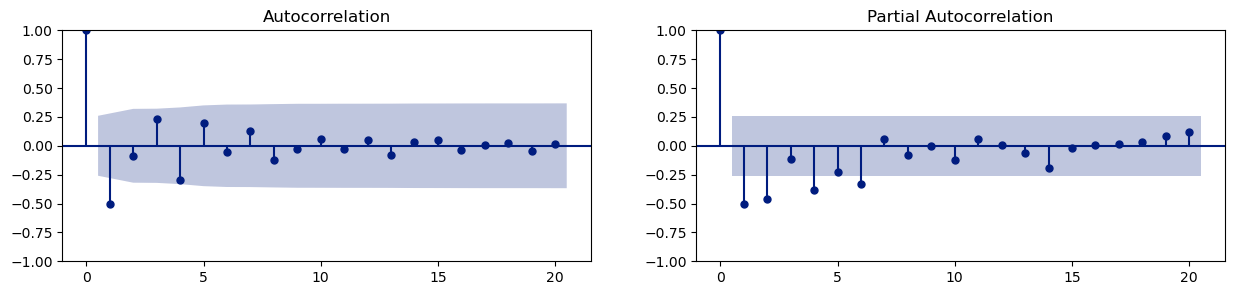

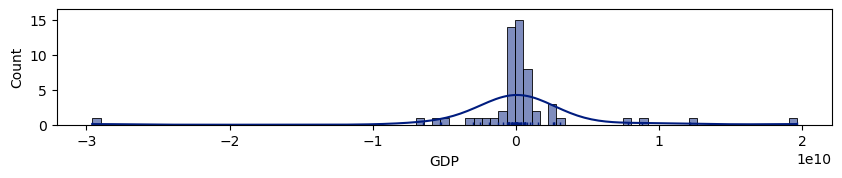

In [19]:
plot_acf_pacf_derivative(train_data['GDP'], 2)
plot_pdf_derivative(train_data['GDP'], 2)

In [20]:
# dt = 1
# train_df_d2 = (train_data['GDP'] - 2 * train_data['GDP'].shift(dt) + train_data['GDP'].shift(2 * dt)).dropna() / dt**2
# plot_acf_pacf(train_df_d2.dropna(), acf_lags=20, pacf_lags=20, size_inches=(18, 3))

#### Дифференцирование 13-го порядка (подбор/проверка)

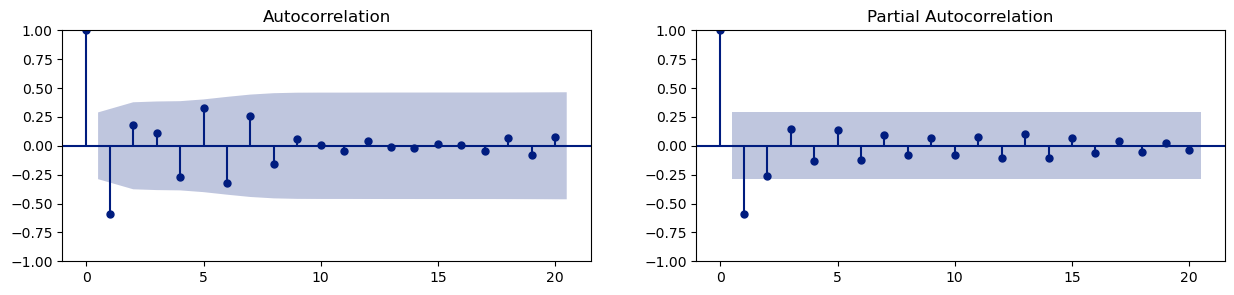

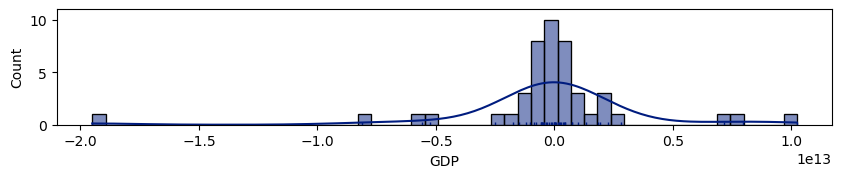

In [21]:
plot_acf_pacf_derivative(train_data['GDP'], 13)
plot_pdf_derivative(train_data['GDP'], 13)

Почти удалось избавиться от автокорреляций только на 13-й производной.<br>
Кореллограмма автокорреляции исходного ряда имеет "хвост" из 13-ти положительных корреляций.

### Дополнительная проверка. Коррелограммы производных логарифмированного ряда и их распределения

#### Исходный логарифм ряда

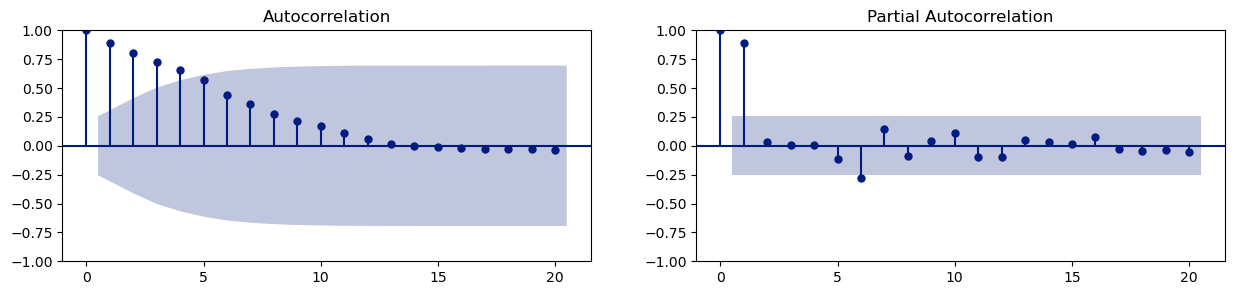

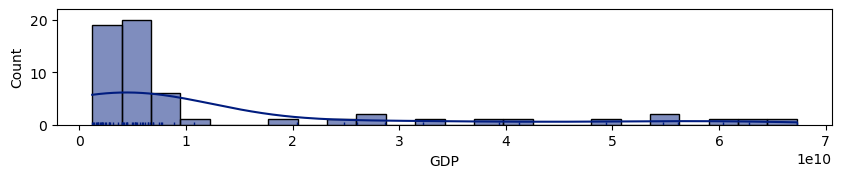

In [22]:
plot_acf_pacf_derivative(train_data['GDP'].replace(0, np.nan).interpolate(method='linear'), 0)
plot_pdf_derivative(train_data['GDP'].replace(0, np.nan).interpolate(method='linear'), 0)

#### Дифференцирование 1-го порядка

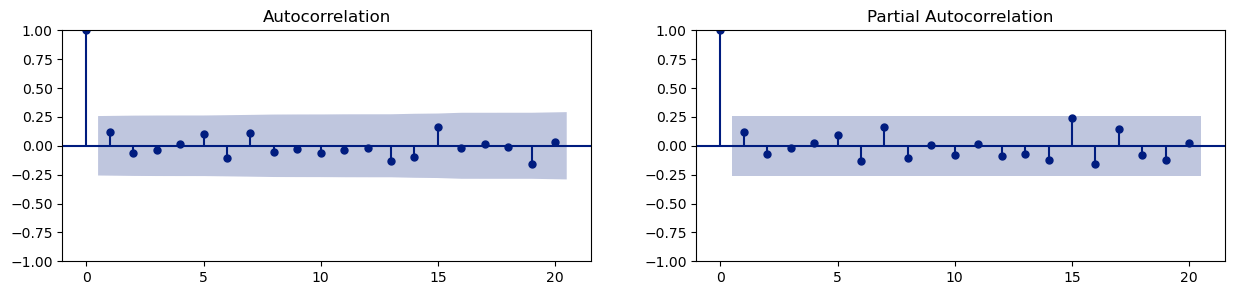

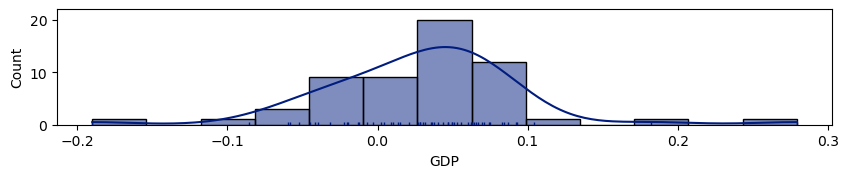

In [23]:
plot_acf_pacf_derivative( np.log10( train_data['GDP'].replace(0, np.nan).interpolate(method='linear') ), 1)
plot_pdf_derivative( np.log10(train_data['GDP'].replace(0, np.nan).interpolate(method='linear') ), 1)

Возможно стоит ограничиться только дифференцированием 1-го порядка.

#### Дифференцирование 2-го порядка

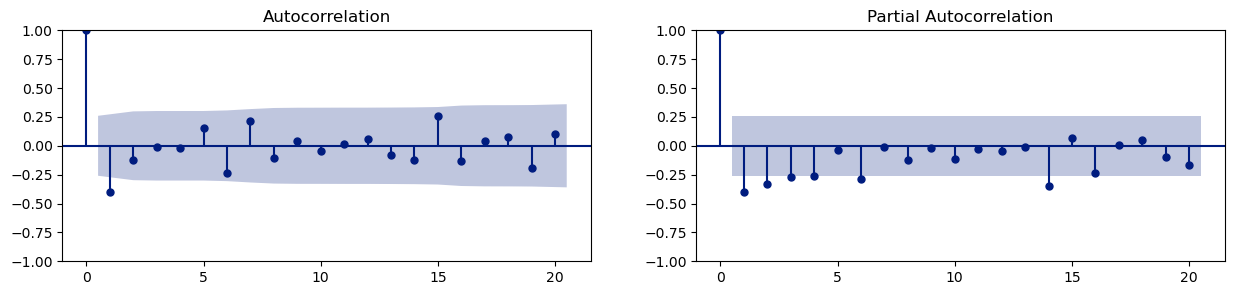

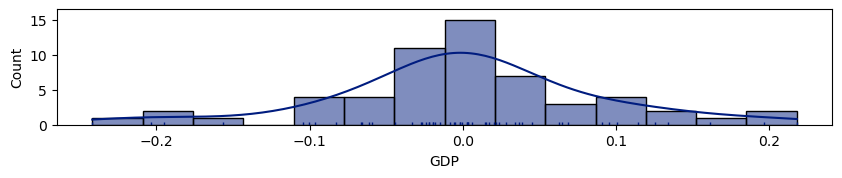

In [24]:
plot_acf_pacf_derivative( np.log10( train_data['GDP'].replace(0, np.nan).interpolate(method='linear') ), 2)
plot_pdf_derivative( np.log10(train_data['GDP'].replace(0, np.nan).interpolate(method='linear') ), 2)

Хотя во 2-м порядке и для логарифма ряда появляются появлявляются лаги со значимыми корреляциями на графике PACF.<br>
В любом случае ряда GDP Ганы получается немного сгладить логарифмированием.

## Пробные модели (с пропусками и с логарифмированием)

### Ряд как есть

#### ARMA

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1392.022
Date:                Thu, 24 Nov 2022   AIC                           2796.044
Time:                        13:50:26   BIC                           2808.509
Sample:                             0   HQIC                          2800.910
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.295e+10    1.5e-12   8.63e+21      0.000     1.3e+10     1.3e+10
ar.L1          0.8147      0.048     16.861      0.000       0.720       0.909
ma.L1          0.8043      0.160      5.023      0.000       0.490       1.118
ma.L2          0.7299      0.085      8.593      0.000       0.563       0.896
ma.L3          0.9085      0.108      8.450      0.000       0.698       1.119
sigma2      1.614e+19   1.45e-20   1.11e+39      0.000    1.61e+19    1.61e+19
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):                66.38
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):              55.58   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+54. Standard errors may be unstable.
"""

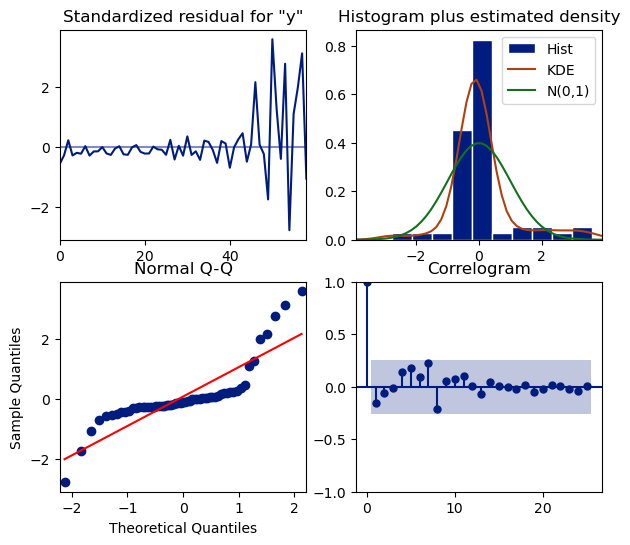

In [25]:
train_data2 = train_data.copy(deep=True)

train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
arima_model = ARIMA(train_data2['GDP'].values,
                   order=(1, 0, 3), seasonal_order=(0, 0, 0, 0),
                   enforce_stationarity=True, enforce_invertibility=True,
                   concentrate_scale=False)
arima_model_fit = arima_model.fit()
display(arima_model_fit.summary())
arima_model_fit.plot_diagnostics(figsize=(7, 6), lags=25);


#### ARIMA

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Thu, 24 Nov 2022   AIC                           2680.765
Time:                        13:50:27   BIC                           2690.980
Sample:                             0   HQIC                          2684.735
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

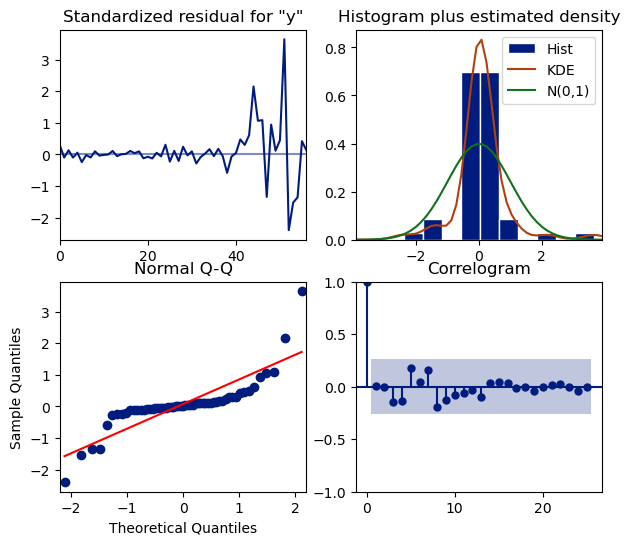

In [26]:
train_data2 = train_data.copy(deep=True)

train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
arima_model = ARIMA(train_data2['GDP'].values,
                   order=(1, 2, 3), seasonal_order=(0, 0, 0, 0),
                   enforce_stationarity=True, enforce_invertibility=True,
                   concentrate_scale=False)
arima_model_fit = arima_model.fit()
display(arima_model_fit.summary())
arima_model_fit.plot_diagnostics(figsize=(7, 6), lags=25);


- Большая гетероскедаичность.
- Остатки явно не образуют белый шум.
- Высокий AIC, но <b>ниже чем для ARMA<b>.
- Очень плохо обусловленная матрица ковариаций.

<b>Модель ARIMA по AIC и по логарифмическому правдоподобию подходит лучше.</b>

#### Перебор p, d, q

##### Grid Search

In [27]:
from time import sleep
from math import isclose
from statsmodels.tsa.arima.model import ARIMAResults


warnings.filterwarnings("ignore")


def arima_gridsearch(time_series, p_range: range, d_range: range, q_range: range):
    pdq_list = list(itertools.product(p_range, d_range, q_range))
    best_result = [list(), (0, 0, 0, 0), 10000000, -10000000]
    for pdq in pdq_list:
        try:
            model = ARIMA(time_series,
                        order=pdq,
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=True,
                        enforce_invertibility=True)

            results: ARIMAResults = model.fit()

            # print(results.test_heteroskedasticity(method=None)[0][0])
            if not np.all([np.isfinite(results.aic),
                       np.isfinite(results.llf),
                       np.all(np.isfinite(results.bse)),
                       np.all(np.isfinite(results.zvalues)),
                       np.all(np.isfinite(results.tvalues)),
                       np.all(np.isfinite(results.test_heteroskedasticity(method=None)))]) or \
                           isclose(results.test_heteroskedasticity(method=None)[0][0] , 0.0, abs_tol=1e-4):
                # print(f'ARIMA{pdq} x {(0, 0, 0, 0)} - AIC: {results.aic}, LLF: {results.llf} - (!!)NaN values(!!)')
                continue

            if results.llf > best_result[3]:
                best_result = [[pdq], (0, 0, 0, 0), results.aic, results.llf]
                print(f'ARIMA{pdq} x {(0, 0, 0, 0)} - AIC: {results.aic}, LLF: {results.llf}')
            elif isclose(results.llf, best_result[3], abs_tol=1e-4):
                best_result[0].append(pdq)
                best_result[2] = results.aic
                best_result[3] = results.llf
                print(f'ARIMA{pdq} x {(0, 0, 0, 0)} - AIC: {results.aic}, LLF: {results.llf} (!) {len(best_result[0])} MODELS with this LLF.')
            else:
                pass
                # print(f'ARIMA{pdq} x {(0, 0, 0, 0)} - AIC: {results.aic}, LLF: {results.llf}')

            sleep(0.02)
        except:
            continue
                
    print('\nBest Result:', best_result)
    best_model = ARIMA(time_series,
                       order=best_result[0][0],
                       seasonal_order=(0, 0, 0, 0),
                       enforce_stationarity=True,
                       enforce_invertibility=True)
    best_model_fit_result = best_model.fit()
    return {
        'best-params': best_result,
        'best-model': best_model,
        'best-model-fit-result': best_model_fit_result
    }
    

In [28]:
train_data2 = train_data.copy(deep=True)
train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)

arima_grid_search_result = arima_gridsearch(
    train_data2['GDP'].values,
    p_range=range(0, 4), d_range=range(0, 4), q_range=range(0, 7)
)
arima_grid_search_result['best-model-fit-result'].summary()

ARIMA(0, 0, 0) x (0, 0, 0, 0) - AIC: 3139.3239153973623, LLF: -1567.6619576986811
ARIMA(0, 0, 1) x (0, 0, 0, 0) - AIC: 2920.3573687025196, LLF: -1457.1786843512598
ARIMA(0, 0, 2) x (0, 0, 0, 0) - AIC: 2918.0450468585395, LLF: -1455.0225234292698
ARIMA(0, 0, 3) x (0, 0, 0, 0) - AIC: 2913.899383811246, LLF: -1451.949691905623
ARIMA(0, 0, 5) x (0, 0, 0, 0) - AIC: 2909.923444668801, LLF: -1447.9617223344005
ARIMA(0, 1, 0) x (0, 0, 0, 0) - AIC: 2730.971841190343, LLF: -1364.4859205951716
ARIMA(0, 1, 3) x (0, 0, 0, 0) - AIC: 2732.6525618858304, LLF: -1362.3262809429152
ARIMA(0, 1, 4) x (0, 0, 0, 0) - AIC: 2734.2108485777417, LLF: -1362.1054242888708
ARIMA(0, 1, 5) x (0, 0, 0, 0) - AIC: 2726.3716127944995, LLF: -1357.1858063972497
ARIMA(0, 1, 6) x (0, 0, 0, 0) - AIC: 2722.9525711483816, LLF: -1354.4762855741908
ARIMA(0, 2, 1) x (0, 0, 0, 0) - AIC: 2683.622497499416, LLF: -1339.811248749708
ARIMA(0, 2, 3) x (0, 0, 0, 0) - AIC: 2686.991569858739, LLF: -1339.4957849293694
ARIMA(0, 2, 4) x (0, 0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:                 ARIMA(3, 3, 3)   Log Likelihood               -1318.361
Date:                Thu, 24 Nov 2022   AIC                           2650.722
Time:                        13:50:36   BIC                           2664.899
Sample:                             0   HQIC                          2656.219
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0219      0.560     -1.826      0.068      -2.119       0.075
ar.L2         -0.3141      0.750     -0.419      0.676      -1.785       1.157
ar.L3          0.0223      0.553      0.040      0.968      -1.061       1.105
ma.L1         -0.8699      0.609     -1.429      0.153      -2.063       0.323
ma.L2         -0.9078      0.510     -1.779      0.075      -1.908       0.092
ma.L3          0.8109      0.336      2.414      0.016       0.152       1.469
sigma2      2.583e+19   1.61e-20    1.6e+39      0.000    2.58e+19    2.58e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               121.10
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             171.24   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.09e+55. Standard errors may be unstable.
"""

Получилась модель **ARIMA(3, 3, 3)**
Однако на практике выяснилось, что простой перебор гипер-параметров модели ARIMA по минимизации AIC может приводить к моделям с низким AIC, но с очень плохой предсказательной способностью и плохим качеством других параметров. По крайней мере для нелогарифмированного ряда с большими числами ВВП. Поэтому ограничимся моделью **ARIMA(1, 2, 3)** на основе кореллограмм.

##### Auto-ARIMA

In [29]:
pipe = pipeline.Pipeline([
    (
        "model", pm.AutoARIMA(
            start_p=0, d=2, start_q=2,
            max_p=3, max_d=4, max_q=5,
            start_P=0, D=0, start_Q=0,
            max_P=0, max_D=0, max_Q=0,
            seasonal=False,
            test='adf',
            stepwise=True,
            trace=True,
            max_iter=100,
            error_action='ignore', suppress_warnings=True
        )
    )
])

train_data2 = train_data.copy(deep=True)
train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
pipe.fit(train_data2['GDP'])
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2693.074, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Thu, 24 Nov 2022   AIC                           2680.765
Time:                        13:50:38   BIC                           2690.980
Sample:                             0   HQIC                          2684.735
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

### Логарифм ряда

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 1, 4)   Log Likelihood                  79.278
Date:                Thu, 24 Nov 2022   AIC                           -144.556
Time:                        13:50:38   BIC                           -130.133
Sample:                    01-01-1960   HQIC                          -138.938
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0299      0.010      3.030      0.002       0.011       0.049
ar.L1         -0.7031      0.308     -2.281      0.023      -1.307      -0.099
ma.L1          0.9184      0.453      2.026      0.043       0.030       1.807
ma.L2         -0.0054      0.283     -0.019      0.985      -0.561       0.550
ma.L3         -0.0686      0.269     -0.256      0.798      -0.595       0.458
ma.L4         -0.1174      0.174     -0.674      0.500      -0.459       0.224
sigma2         0.0037      0.001      4.144      0.000       0.002       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                23.95
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               4.54   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

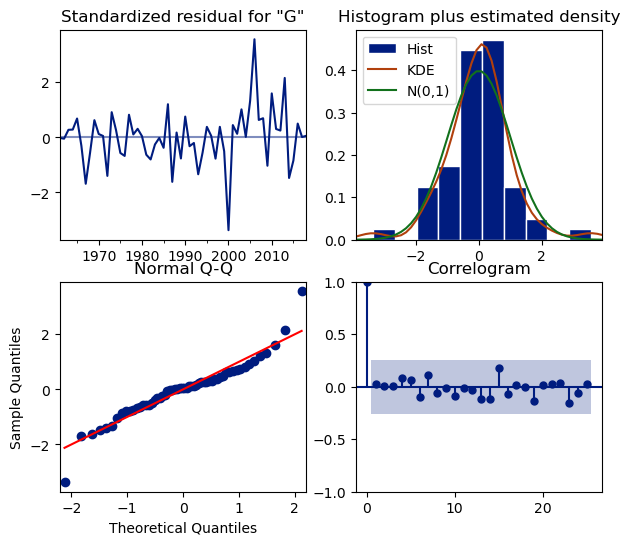

In [30]:
train_data2 = train_data.copy(deep=True)

train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
arima_model_log = ARIMA(np.log10(train_data2['GDP'].replace(0, np.nan).interpolate(method='linear')),
                   order=(1, 1, 4), seasonal_order=(0, 0, 0, 0),
                   trend='t', # явно определённый линейный тренд даёт ещё немного лучший результат (AIC -144 vs -137)
                   enforce_stationarity=True, enforce_invertibility=True,
                   concentrate_scale=False)
arima_model_log_fit = arima_model_log.fit()
display(arima_model_log_fit.summary())
arima_model_log_fit.plot_diagnostics(figsize=(7, 6), lags=25);

Логарифмированный ряд (порядки ВВП) показывает намного лучший результат.
- Низкая гетероскедаичность по сравнению с моделями для изначального ряда.
- Остатки похожи на белый шум.
- Низкий AIC, высокое Log Likelihood.
- Матрица ковариаций хорошо обусловлена.

<b>Модель ARIMA явно работает лучше (в том числе численно) с<br>
<i>логарифмированным рядом показателей ВВП</i> - больш'их по значениям и возрастающих нелинейно (в выбранный исторический период).</b>

#### Перебор p, d, q

##### Grid Search

In [31]:
train_data2 = train_data.copy(deep=True)
train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)

arima_grid_search_result = arima_gridsearch(
    np.log10(train_data2['GDP'].replace(0, np.nan).interpolate(method='linear')),
    p_range=range(0, 6), d_range=range(0, 6), q_range=range(0, 6)
)
arima_grid_search_result['best-model-fit-result'].summary()

ARIMA(0, 0, 0) x (0, 0, 0, 0) - AIC: 86.26835121082235, LLF: -41.13417560541117
ARIMA(0, 0, 1) x (0, 0, 0, 0) - AIC: 15.827904231574557, LLF: -4.9139521157872785
ARIMA(0, 0, 2) x (0, 0, 0, 0) - AIC: -29.752227407985124, LLF: 18.876113703992562
ARIMA(0, 0, 3) x (0, 0, 0, 0) - AIC: -65.15704628904095, LLF: 37.578523144520474
ARIMA(0, 0, 4) x (0, 0, 0, 0) - AIC: -74.56238870233751, LLF: 43.28119435116876
ARIMA(0, 0, 5) x (0, 0, 0, 0) - AIC: -94.7133461097551, LLF: 54.35667305487755
ARIMA(0, 1, 0) x (0, 0, 0, 0) - AIC: -139.1541901123984, LLF: 70.5770950561992
ARIMA(0, 1, 1) x (0, 0, 0, 0) - AIC: -141.02274416500677, LLF: 72.51137208250339
ARIMA(0, 1, 2) x (0, 0, 0, 0) - AIC: -139.3493568215513, LLF: 72.67467841077566
ARIMA(0, 1, 3) x (0, 0, 0, 0) - AIC: -137.67100031598463, LLF: 72.83550015799231
ARIMA(0, 1, 4) x (0, 0, 0, 0) - AIC: -135.76969575084564, LLF: 72.88484787542282
ARIMA(0, 1, 5) x (0, 0, 0, 0) - AIC: -140.35997099235988, LLF: 76.17998549617994
ARIMA(1, 1, 5) x (0, 0, 0, 0) - A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(4, 1, 5)   Log Likelihood                  81.068
Date:                Thu, 24 Nov 2022   AIC                           -142.135
Time:                        13:51:12   BIC                           -121.531
Sample:                    01-01-1960   HQIC                          -134.109
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9876      0.735     -1.343      0.179      -2.429       0.454
ar.L2          0.4036      0.525      0.769      0.442      -0.625       1.432
ar.L3          1.1241      0.576      1.952      0.051      -0.004       2.253
ar.L4          0.4000      0.653      0.613      0.540      -0.880       1.680
ma.L1          1.4057      1.043      1.348      0.178      -0.638       3.449
ma.L2         -0.0063      1.373     -0.005      0.996      -2.697       2.684
ma.L3         -1.3076      0.671     -1.948      0.051      -2.623       0.008
ma.L4         -0.8051      1.296     -0.621      0.534      -3.345       1.734
ma.L5          0.0737      0.508      0.145      0.885      -0.922       1.069
sigma2         0.0032      0.002      2.011      0.044    8.21e-05       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                23.49
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Получена модель **ARIMA(4, 1, 5)**.

##### Auto-ARIMA

In [32]:
pipe = pipeline.Pipeline([
    (
        "model", pm.AutoARIMA(
            start_p=1, d=1, start_q=4,
            trend='t',
            seasonal=False,
            test='adf',
            stepwise=True,
            trace=True,
            max_iter=1000,
            error_action='ignore', suppress_warnings=True
        )
    )
])

train_data2 = train_data.copy(deep=True)
train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
pipe.fit(np.log10(train_data2['GDP'].replace(0, np.nan).interpolate(method='linear')))
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-142.430, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-148.922, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-147.608, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-147.744, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-148.922, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-145.897, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  76.461
Date:                Thu, 24 Nov 2022   AIC                           -148.922
Time:                        13:51:12   BIC                           -144.801
Sample:                             0   HQIC                          -147.317
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0009      0.000      4.270      0.000       0.000       0.001
sigma2         0.0042      0.000      8.985      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                32.15
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               3.87   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Для логарифмированного ряда ВВП также подходит модель 'ARIMA(0, 1, 0)', но у неё ниже Log Likelihood.

<b>Модель ARIMA лучше, чем модель ARMA<br>
Принято решение, использовать следующие модели:</b>
- ARIMA(6, 11, 10) для изначальных значений ряда,
- ARIMA(2, 1, 2) для логарифмированного ряда.

## Предсказание для найденной лучшей модели на тестовой выборке

In [33]:
def train_arima_model(train_data, order, seasonal_order, trend=None, exog=None):
    arima_model = ARIMA(
        train_data,
        exog=exog,
        order=order, seasonal_order=seasonal_order,
        trend=trend,
        enforce_stationarity=True, enforce_invertibility=True,
        concentrate_scale=False
    )
    arima_model_fit = arima_model.fit()
    return arima_model_fit


def make_predictions(model, test_data, original_data, target_column, significance_level=0.05, exog=None):
    predicted_data = pd.DataFrame(index=original_data.index)

    predicted_data['model_predictions'] = model.predict(
        start=test_data.index[0], end=test_data.index[-1], exog=exog
    )
    predicted_data[target_column] = original_data[target_column]

    model_forecast = model.get_forecast(len(test_data.index), exog=exog)
    forecast_data = model_forecast.conf_int(
        alpha=significance_level)  # Confidence level of (1 - alpha) * 100%

    predicted_data.at[test_data.index,
                      "model_predictions_lower"] = forecast_data[f"lower {target_column}"]
    predicted_data.at[test_data.index,
                      "model_predictions_upper"] = forecast_data[f"upper {target_column}"]

    return predicted_data


def plot_predictions(predicted_data, test_data,
                     target_column,
                     predictions_column,
                     predictions_column_lower,
                     predictions_column_upper,
                     size_inches):
    fig, ax = plt.subplots(2, 1)

    fig.set_size_inches(*size_inches)

    sns.lineplot(data=predicted_data,
                 x=predicted_data.index, y=target_column, color='blue', ax=ax[0],
                 label="Actuals")
    sns.lineplot(data=predicted_data.loc[test_data.index],
                 x=test_data.index, y=predictions_column, color='red', ax=ax[0],
                 label="Out of Sample Fit")

    sns.lineplot(data=predicted_data.loc[test_data.index], x=test_data.index, y=predictions_column_lower,
                 color='darkgreen', linestyle="dashed", ax=ax[0], label='Confidence Intervals (95%) - Lower')
    sns.lineplot(data=predicted_data.loc[test_data.index], x=test_data.index, y=predictions_column_upper,
                 color='lightgreen', linestyle="dashed", ax=ax[0], label='Confidence Intervals (95%) - Upper')
    plt.legend()

    # -----

    sns.lineplot(data=predicted_data.loc[test_data.index],
                 x=test_data.index, y=target_column, color='blue', ax=ax[1],
                 label="Actuals")
    sns.lineplot(data=predicted_data.loc[test_data.index],
                 x=test_data.index, y=predictions_column, color='red', ax=ax[1],
                 label="Out of Sample Fit")

    sns.lineplot(data=predicted_data.loc[test_data.index], x=test_data.index, y=predictions_column_lower,
                 color='darkgreen', linestyle="dashed", ax=ax[1], label='Confidence Intervals (95%) - Lower')
    sns.lineplot(data=predicted_data.loc[test_data.index], x=test_data.index, y=predictions_column_upper,
                 color='lightgreen', linestyle="dashed", ax=ax[1], label='Confidence Intervals (95%) - Upper')
    ax[1].set_xticks(test_data.index)
    plt.legend()

    plt.show()


### Изначальный временной ряд

ARIMA(1, 2, 3)

#### Обучение

In [34]:
arima_model = train_arima_model(
    train_data['GDP'],
    order=(1, 2, 3), seasonal_order=(0, 0, 0, 0)
)

In [35]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Thu, 24 Nov 2022   AIC                           2680.765
Time:                        13:51:12   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

#### Прогноз

In [36]:
predicted_data = make_predictions(
    arima_model, test_data,
    original_data=data, target_column='GDP',
    significance_level=0.05
)

predicted_data.loc[test_data.index]

,model_predictions,GDP,model_predictions_lower,model_predictions_upper
year,,,,
2019-01-01,6.789080e+10,6.833754e+10,5.941329e+10,7.636831e+10
2020-01-01,7.253326e+10,7.004320e+10,6.050774e+10,8.455877e+10
2021-01-01,7.517348e+10,7.759428e+10,6.155656e+10,8.879040e+10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


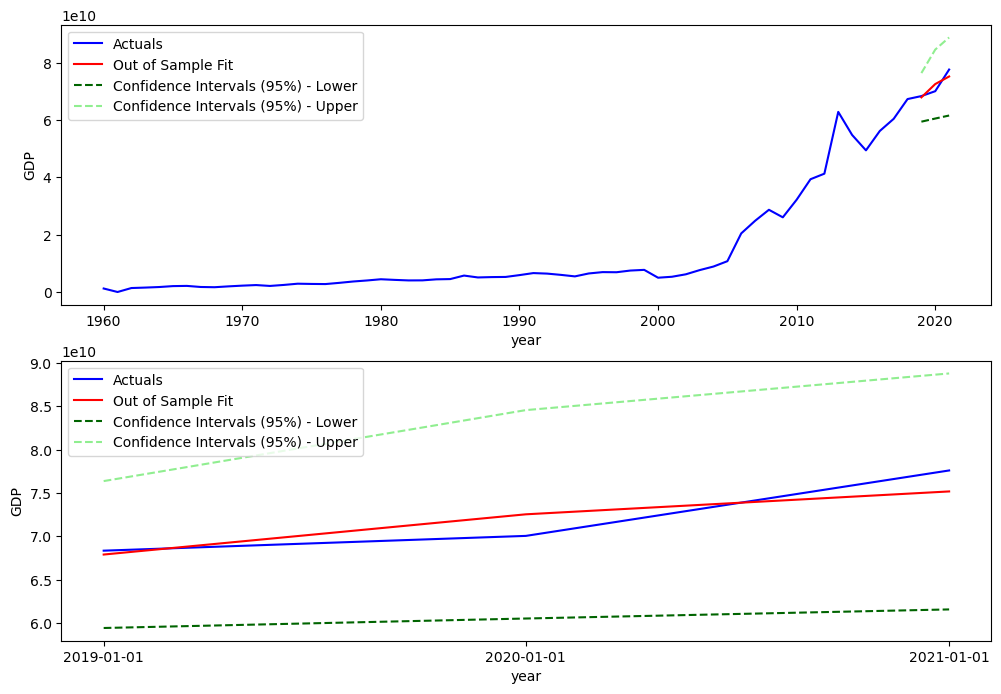

In [37]:
plot_predictions(
    predicted_data, test_data,
    target_column='GDP',
    predictions_column='model_predictions',
    predictions_column_lower='model_predictions_lower',
    predictions_column_upper='model_predictions_upper',
    size_inches=(12, 8)
)

Модель ARIMA(p=1, d=2, q=3) может предсказывать GDP Ганы по крайней мере на три года вперёд с уровнем доверия 95%.

### Логарифмированный временной ряд

ARIMA(4, 1, 5)

#### Обучение

In [38]:
arima_model_log10 = train_arima_model(
    np.log10(train_data['GDP'].replace(0, np.nan).interpolate(method='linear')),
    order=(4, 1, 5), seasonal_order=(0, 0, 0, 0),
    trend='t'
)

#### Прогноз

In [39]:
predicted_data_log10 = make_predictions(
    arima_model_log10,
    np.log10(test_data.replace(0, np.nan).interpolate(method='linear')),
    original_data=np.log10(data.replace(0, np.nan).interpolate(method='linear')),
    target_column='GDP',
    significance_level=0.05
)

predicted_data_log10.loc[test_data.index]

,model_predictions,GDP,model_predictions_lower,model_predictions_upper
year,,,,
2019-01-01,10.842290,10.834659,10.723066,10.961514
2020-01-01,10.865859,10.845366,10.677394,11.054325
2021-01-01,10.900050,10.889830,10.673632,11.126469


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


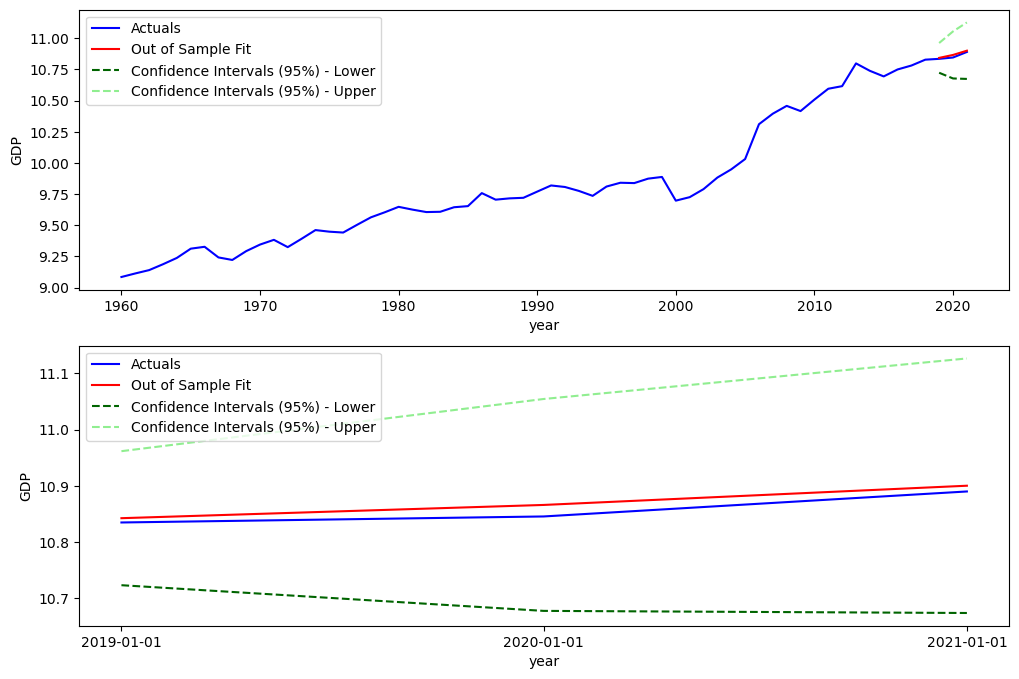

In [40]:
plot_predictions(
    predicted_data_log10,
    np.log10(test_data.replace(0, np.nan).interpolate(method='linear')),
    target_column='GDP',
    predictions_column='model_predictions',
    predictions_column_lower='model_predictions_lower',
    predictions_column_upper='model_predictions_upper',
    size_inches=(12, 8)
)

Модель ARIMA(p=4, d=1, q=5) с трендом 't' (линейным) для логарифмированного ряда может работать ещё лучше для прогнозирования ВВП.

## Удаление пропусков

In [41]:
date_min = data.index.min()
date_max = data.index.max()
print(date_min)
print(date_max)

print(f"Количество пропусков (NaN): {data.GDP.asfreq(freq='AS').isna().sum()}")
print(f"Количество пропусков (NaN) 2-й способ: {data.reindex(pd.date_range(date_min, date_max, freq='AS')).isnull().all(1).sum()}")

data_cleaned = data.replace(0, np.nan)
print(f"Количество нулевых или отрицательных значений: {data_cleaned.isna().sum()}")
print('----------')
print('Фактически найденные пропуски:')
display(data_cleaned['GDP'][data_cleaned['GDP'].isna()])
print('----------')

1960-01-01 00:00:00
2021-01-01 00:00:00
Количество пропусков (NaN): 0
Количество пропусков (NaN) 2-й способ: 0
Количество нулевых или отрицательных значений: GDP    1
dtype: int64
----------
Фактически найденные пропуски:


year
1961-01-01   NaN
Name: GDP, dtype: float64

----------


In [42]:
data_cleaned.interpolate(method='linear', inplace=True)
print('----------')
print('Фактически найденные пропуски:')
display(data_cleaned['GDP'][data_cleaned['GDP'].isna()].shape[0])
print('----------')

----------
Фактически найденные пропуски:


0

----------


In [43]:
data = data_cleaned
data.head(3)

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


## Повторное разбиение на тестовую и тренировочную выборки

In [44]:
train_data = data.loc[:"2018-12-31"]
test_data = data.loc["2019-01-01":]
train_data.shape, test_data.shape

((59, 1), (3, 1))

In [45]:
train_data.head(3)

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


## Стационарность ряда GDP после удаления пропусков

### Кореллограммы

#### Автокорреляция

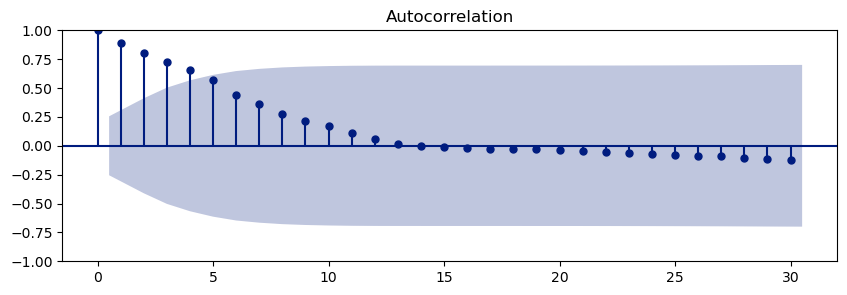

In [46]:
plot_acf(data=train_data['GDP'], lags=30, size_inches=(10, 3))

До 15-го лага имеется положительная автокорреляция. Затем она постепенно становится отрицательной, но незначительно<br>
Значительная автокорреляция сохраняется для 3-4 лагов (годов).
Положим q = 3.

In [47]:
q = 3

#### Частичная автокорреляция

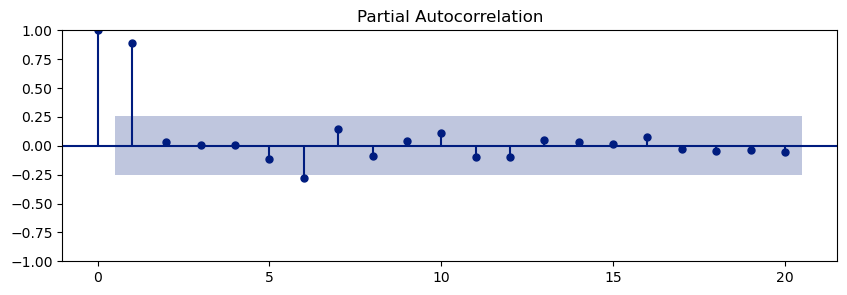

In [48]:
plot_pacf(data=train_data['GDP'], lags=20, size_inches=(10, 3))

Порядок возможной авторегрессионной модели - 1. Положим p = 1.

In [49]:
p = 1

#### Тест Дики-Фуллера

##### Тест изначального ряда

In [50]:
test_dickey_fuller(train_data, maxlag=20)

adf: 2.145
p-value: 0.999
used lag:  16
Critical values:  {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
----------
Ряд нестационарен: статистика теста 2.145 больше критического значения -2.933 для уровня значимости 5%.


- Статистика теста Дики-Фуллера значительно выше всех критических значений.
- Графики скользящих средних значительно выше соответствующих графиков стандартных отклонений и возрастают со временем.
- Стандартное отклонение (дисперсия) непостоянна.

<i>Положительная аддитивная модель роста</i><br>
<b>Ряд нестационарен</b>

## Перебор p, d, q

In [51]:
pipe = pipeline.Pipeline([
    (
        "model", pm.AutoARIMA(
            start_p=0, d=2, start_q=2,
            max_p=3, max_d=4, max_q=5,
            start_P=0, D=0, start_Q=0,
            max_P=0, max_D=0, max_Q=0,
            seasonal=False,
            test='adf',
            stepwise=True,
            trace=True,
            max_iter=100,
            error_action='ignore', suppress_warnings=True
        )
    )
])

train_data2 = train_data.copy(deep=True)
train_data2.index = pd.DatetimeIndex(
    train_data2.index.values, freq=train_data2.index.inferred_freq)
pipe.fit(train_data2['GDP'])
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2693.802, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Thu, 24 Nov 2022   AIC                           2680.513
Time:                        13:51:16   BIC                           2690.729
Sample:                             0   HQIC                          2684.483
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+55. Standard errors may be unstable.
"""

Параметры модели не поменялись. Также не поменялся вывод о том, что ряд стоит логарифмировать.

<b>AIC был до устранения пропусков - 2680.765, после AIC - 2680.513, то есть незначительно лучше.</b>

## Добавление логарифмированного ряда в таблицу

In [52]:
data['log10_GDP'] = np.log10(data['GDP'])
data.head()

,GDP,log10_GDP
year,,
1960-01-01,1.217087e+09,9.085322
1961-01-01,1.299720e+09,9.113850
1962-01-01,1.382353e+09,9.140619
1963-01-01,1.540616e+09,9.187694
1964-01-01,1.731092e+09,9.238320


## Гетероскедатичность. Волатильность

### Относительное изменение GDP

#### Оригинальный ряд

<AxesSubplot:xlabel='year', ylabel='GDP Percentage Change'>

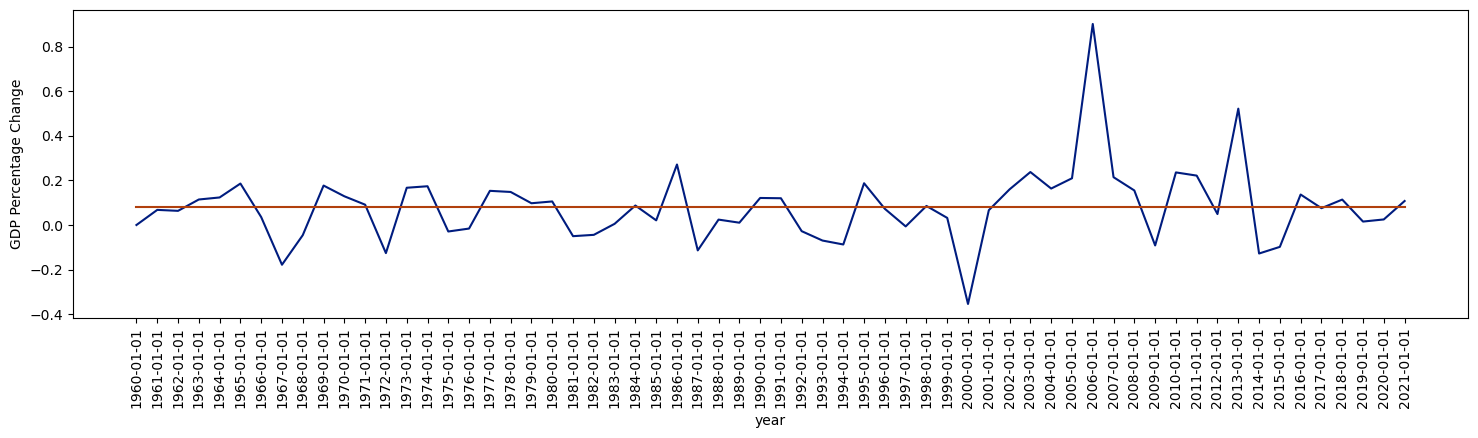

In [53]:
GDP_pct_change = data['GDP'].pct_change(1).fillna(0)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(GDP_pct_change.index)
ax.set_xticklabels(GDP_pct_change.index.strftime('%Y-%m-%d'), rotation=90)
ax.set_ylabel('GDP Percentage Change')
sns.lineplot(x=GDP_pct_change.index, y=GDP_pct_change, ax=ax)
sns.lineplot(x=GDP_pct_change.index, y=GDP_pct_change.mean(), ax=ax)

Интересен резкий рос ВВП c 2005-го года по 2006 год на 90%. Похоже на некий выброс.

#### Логарифм

<AxesSubplot:xlabel='year', ylabel='log10(GDP) Percentage Change'>

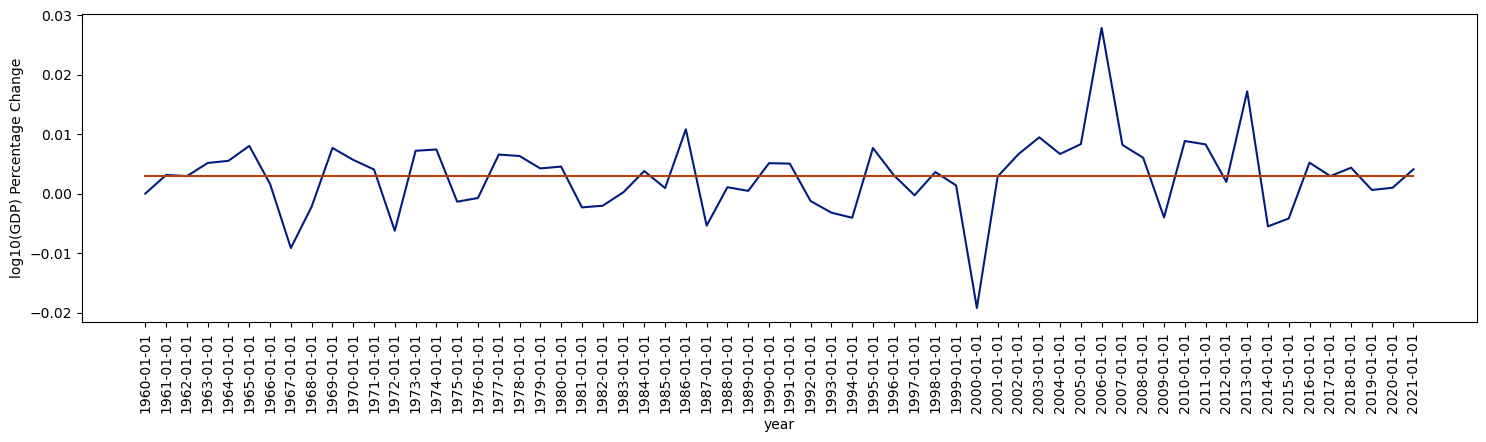

In [54]:
log10_GDP_pct_change = data['log10_GDP'].pct_change(1).fillna(0)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(log10_GDP_pct_change.index)
ax.set_xticklabels(log10_GDP_pct_change.index.strftime('%Y-%m-%d'), rotation=90)
ax.set_ylabel('log10(GDP) Percentage Change')
sns.lineplot(x=log10_GDP_pct_change.index, y=log10_GDP_pct_change, ax=ax)
sns.lineplot(x=log10_GDP_pct_change.index, y=log10_GDP_pct_change.mean(), ax=ax)

In [55]:
data['GDP_pct_change'] = GDP_pct_change
data['log10_GDP_pct_change'] = log10_GDP_pct_change
data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change
year,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510


### Волатильность GDP

#### Оригинальный ряд

<AxesSubplot:xlabel='year', ylabel='GDP Volatility'>

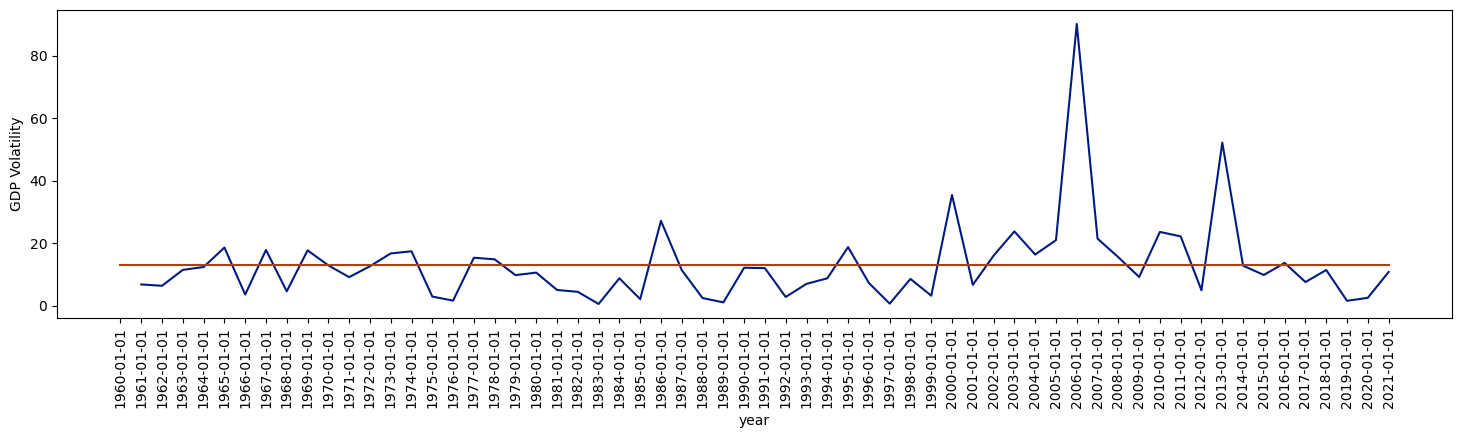

In [56]:
GDP_volatility = data['GDP'].pct_change(1).mul(100).abs()
# GDP_volatility = ( (data['GDP'] - data['GDP'].shift(1)) / data['GDP'].shift(1) ).mul(100).abs()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(GDP_volatility.index)
ax.set_xticklabels(GDP_volatility.index.strftime('%Y-%m-%d'), rotation=90)
ax.set_ylabel('GDP Volatility')
sns.lineplot(x=GDP_volatility.index, y=GDP_volatility, ax=ax)
sns.lineplot(x=GDP_volatility.index, y=GDP_volatility.mean(), ax=ax)

#### Логарифм

<AxesSubplot:xlabel='year', ylabel='log10(GDP) Volatility'>

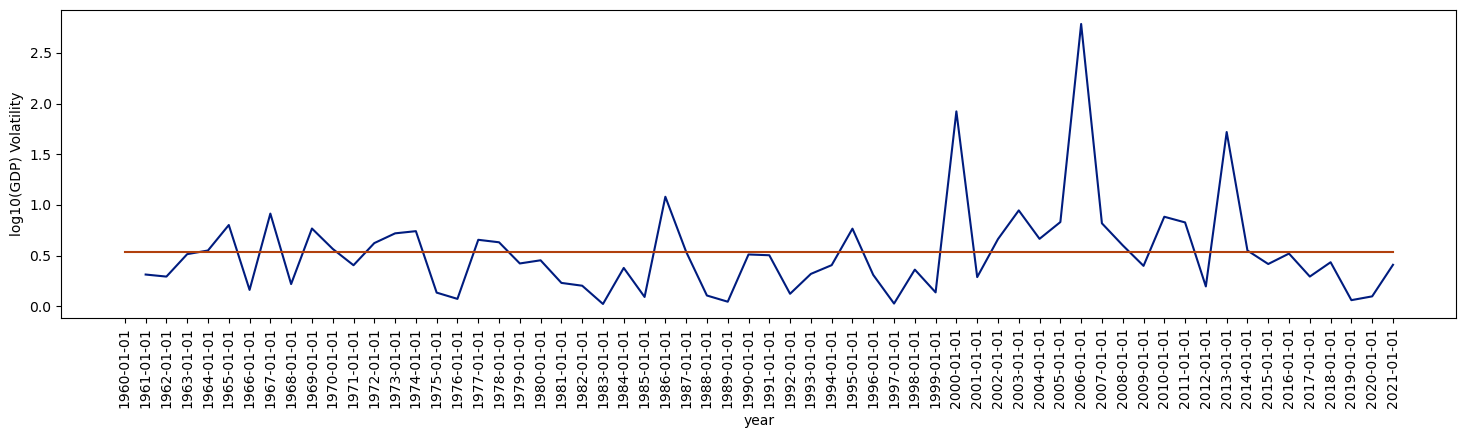

In [57]:
log10_GDP_volatility = data['log10_GDP'].pct_change(1).mul(100).abs()
# log10_GDP_volatility = ( (data['log10_GDP'] - data['log10_GDP'].shift(1)) / data['log10_GDP'].shift(1) ).mul(100).abs()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(log10_GDP_volatility.index)
ax.set_xticklabels(log10_GDP_volatility.index.strftime('%Y-%m-%d'), rotation=90)
ax.set_ylabel('log10(GDP) Volatility')
sns.lineplot(x=log10_GDP_volatility.index, y=log10_GDP_volatility, ax=ax)
sns.lineplot(x=log10_GDP_volatility.index, y=log10_GDP_volatility.mean(), ax=ax)

In [58]:
data['GDP_volatility'] = GDP_volatility
data['log10_GDP_volatility'] = log10_GDP_volatility
data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000,NaN,NaN
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140,6.789413,0.314003
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937,6.357759,0.293720
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150,11.448835,0.515015
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510,12.363636,0.551017


#### Повторное разбиение на обучающую и тестовую выборки

In [59]:
train_data = data.loc[:"2018-12-31"]
test_data = data.loc["2019-01-01":]
train_data.shape, test_data.shape

((59, 6), (3, 6))

In [60]:
train_data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000,NaN,NaN
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140,6.789413,0.314003
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937,6.357759,0.293720
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150,11.448835,0.515015
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510,12.363636,0.551017


In [61]:
test_data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
2019-01-01,6.833754e+10,10.834659,0.015427,0.000614,1.542746,0.061405
2020-01-01,7.004320e+10,10.845366,0.024959,0.000988,2.495937,0.098819
2021-01-01,7.759428e+10,10.889830,0.107806,0.004100,10.780603,0.409979


#### Дополнительные графики CDF и PDF для ВВП Ганы

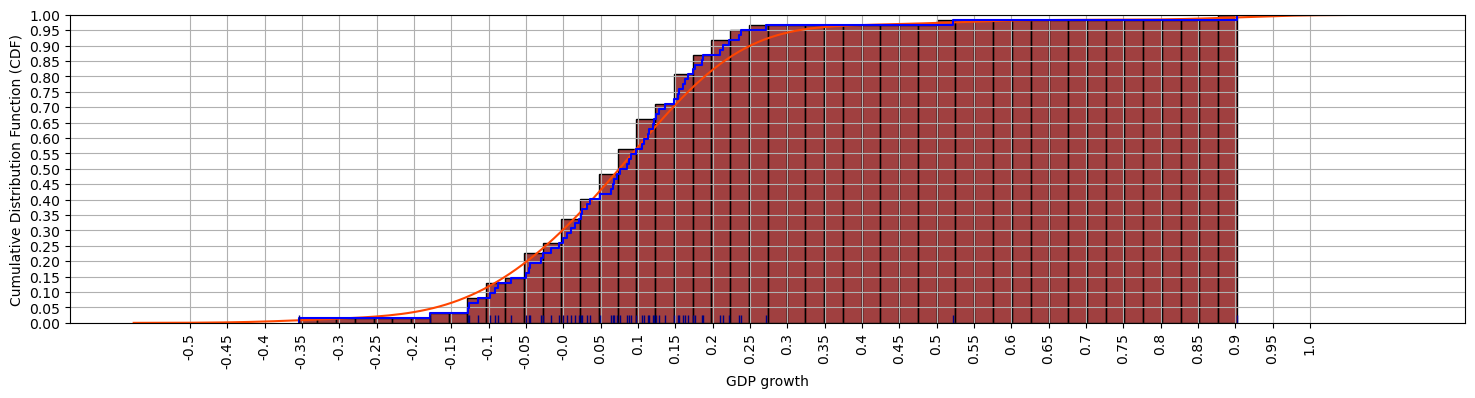

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
ax.grid()
ax.set_xlabel('GDP growth')
ax.set_xticks(np.arange(-0.5, 1.0 + 0.05, 0.05).tolist())
ax.set_xticklabels(np.round(np.arange(-0.5, 1.0 + 0.05, 0.05), 2).tolist(), rotation=90)
ax.set_ylabel('Cumulative Distribution Function (CDF)')
ax.set_yticks(np.arange(0.0, 1.0 + 0.05, 0.05).tolist())
sns.kdeplot(data=data['GDP_pct_change'], color='orangered', cumulative=True, ax=ax)
sns.ecdfplot(data=data['GDP_pct_change'], color='blue', ax=ax)
sns.histplot(data=data['GDP_pct_change'], color='maroon', bins=50, stat='probability', cumulative=True, ax=ax)
sns.rugplot(data=data['GDP_pct_change'], color='navy', ax=ax)
plt.show()

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True
# count, bins_count = np.histogram(GDP_change, bins=len(GDP_change))
# cdf_GDP_change = pd.DataFrame({'gdp_growth': bins_count[1:], 'cdf': np.cumsum( count / sum(count) )})
# plt.plot(cdf_GDP_change.gdp_growth, cdf_GDP_change.cdf, label="CDF")
# plt.legend()
# plt.show()

In [63]:
from scipy.interpolate import CubicSpline

def cspline_interpolation(X, Y):
    spline = CubicSpline(X, Y)
    return lambda x: spline(x).tolist()


def pdf_time_series(data, column_names=['X', 'Y']):
    count, bins_count = np.histogram(data, bins=len(data))
    pdf_table = pd.DataFrame({column_names[0]: bins_count[1:], column_names[1]: count / sum(count)})
    return pdf_table


def cdf_time_series(data, column_names=['X', 'Y']):
    count, bins_count = np.histogram(data, bins=len(data))
    cdf_table = pd.DataFrame({column_names[0]: bins_count[1:], column_names[1]: np.cumsum( count / sum(count) )})
    return cdf_table


In [64]:
cdf_gdp_table = cdf_time_series(data['GDP_pct_change'], column_names=['gdp_growth', 'cdf'])
cdf_gdpchange = cspline_interpolation(cdf_gdp_table['gdp_growth'], cdf_gdp_table['cdf'])

In [65]:
P_GDP_growth_high = cdf_gdpchange(0.902) - cdf_gdpchange(0.20)
P_GDP_moderate_positive = cdf_gdpchange(0.20) - cdf_gdpchange(0.0)
P_GDP_negative = cdf_gdpchange(0.0) - cdf_gdpchange(-0.334)

print(f"Вероятность высокого ВВП: {P_GDP_growth_high:.2f}")
print(f"Вероятность умеренно положительного ВВП: {P_GDP_moderate_positive:.2f}")
print(f"Вероятность отрицательного ВВП: {P_GDP_negative:.2f}")
print(f"Сумма: {(P_GDP_growth_high + P_GDP_moderate_positive + P_GDP_negative):.2f}")

Вероятность высокого ВВП: 0.12
Вероятность умеренно положительного ВВП: 0.61
Вероятность отрицательного ВВП: 0.26
Сумма: 0.98


Пока что конкретно этот показатель ВВП https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=GH <br>
сильно растёт вверх последние годы. <br>
- Вероятность, что он растёт в год от 20% до 100% составляет 12%.
- Вероятность, что он растёт в год от 0% до 20% составляет 61%.
- Вероятность, что прирост отрицателен - 26%.

<AxesSubplot:xlabel='gdp_growth', ylabel='pdf'>

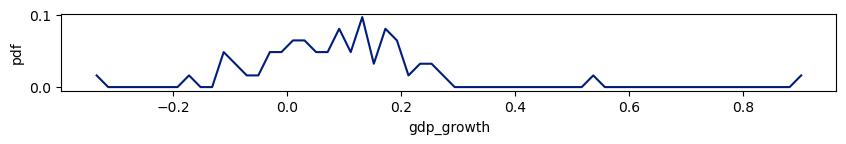

In [66]:
pdf_gdp_table = pdf_time_series(data['GDP_pct_change'], column_names=['gdp_growth', 'pdf'])
sns.lineplot(data=pdf_gdp_table, x='gdp_growth', y='pdf')

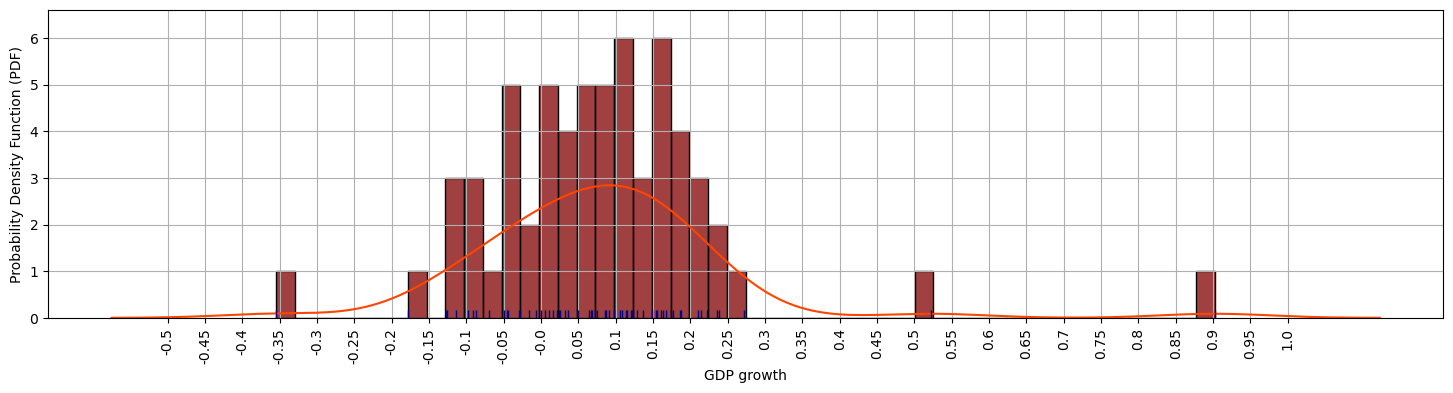

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
ax.grid()
ax.set_xlabel('GDP growth')
ax.set_xticks(np.arange(-0.5, 1.0 + 0.05, 0.05).tolist())
ax.set_xticklabels(np.round(np.arange(-0.5, 1.0 + 0.05, 0.05), 2).tolist(), rotation=90)
ax.set_ylabel('Probability Density Function (PDF)')
# ax.set_yticks(np.arange(0.0, 1.0 + 0.05, 0.05).tolist())
sns.kdeplot(data=data['GDP_pct_change'], color='orangered', cumulative=False, common_norm=True, ax=ax)
sns.histplot(data=data['GDP_pct_change'], color='maroon', bins=50, cumulative=False, ax=ax)
sns.rugplot(data=data['GDP_pct_change'], color='navy', ax=ax)
plt.show()

Изначальное распределение для ВВП ассиметрично и скошено влево.

#### Коррелограммы PACF для ряда волатильности и для GDP

##### Для волатильности

<AxesSubplot:xlabel='year'>

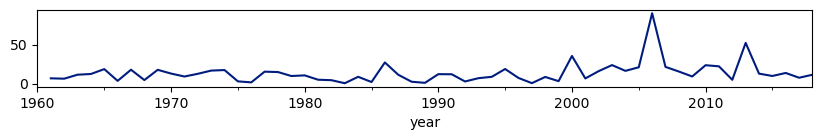

In [68]:
train_data['GDP_volatility'].plot()

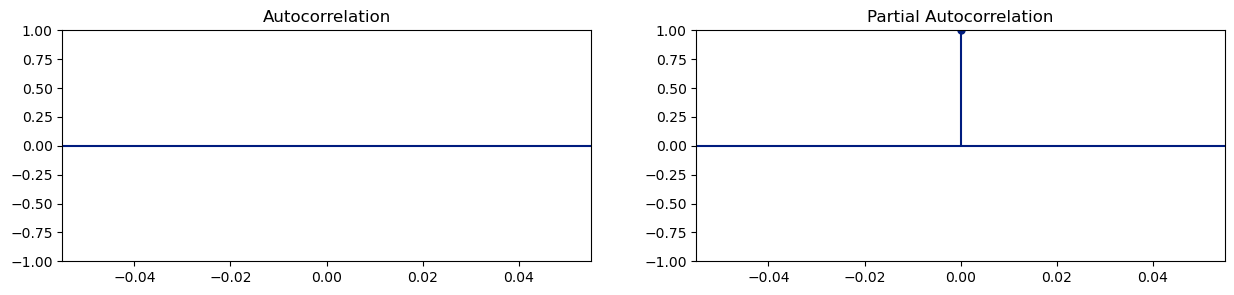

In [69]:
plot_acf_pacf(data=train_data['GDP_volatility'], acf_lags=20, pacf_lags=20, size_inches=(15, 3))
# plot_pacf(data=train_data['GDP_volatility'].dropna(), lags=20, size_inches=(10, 3))

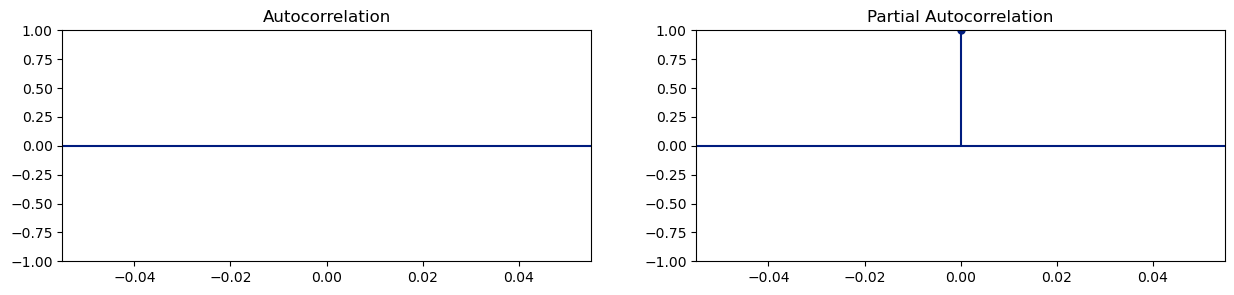

In [70]:
plot_acf_pacf(data=train_data['log10_GDP_volatility'], acf_lags=20, pacf_lags=20, size_inches=(15, 3))
# plot_pacf(data=train_data['log10_GDP_volatility'].dropna(), lags=20, size_inches=(10, 3))

##### Для GDP (дублирование графиков выше)

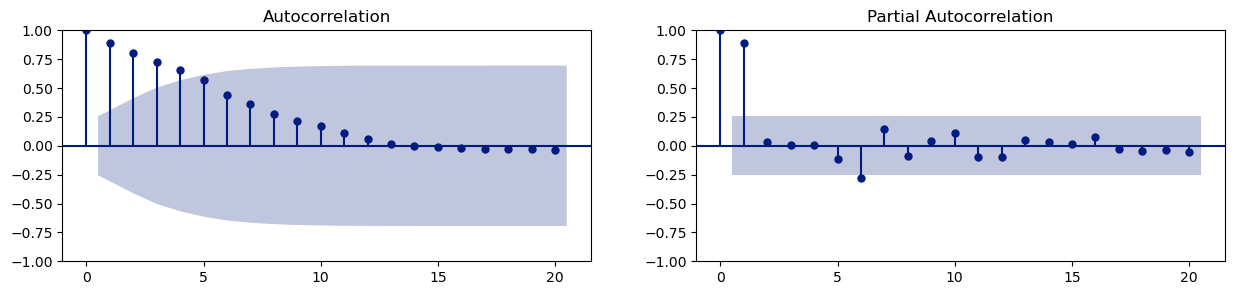

In [71]:
plot_acf_pacf(data=train_data['GDP'], acf_lags=20, pacf_lags=20, size_inches=(15, 3))
# plot_pacf(data=train_data['GDP'], lags=20, size_inches=(10, 3))

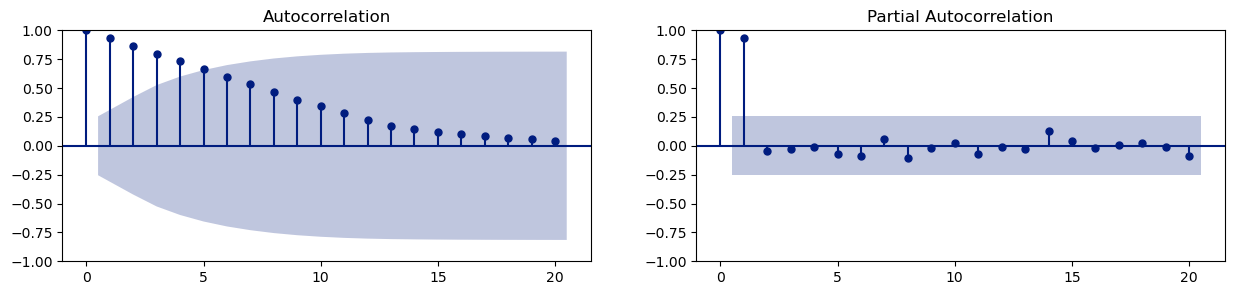

In [72]:
plot_acf_pacf(data=train_data['log10_GDP'], acf_lags=20, pacf_lags=20, size_inches=(15, 3))
# plot_pacf(data=train_data['log10_GDP'], lags=20, size_inches=(10, 3))

#### Тест Дики-Фуллера

In [73]:
test_dickey_fuller(train_data['GDP_volatility'].dropna(), maxlag=20)

adf: -6.725
p-value: 0.000
used lag:  0
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
----------
Ряд стационарен


In [74]:
test_dickey_fuller(train_data['log10_GDP_volatility'].dropna(), maxlag=20)

adf: -7.088
p-value: 0.000
used lag:  0
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
----------
Ряд стационарен


<AxesSubplot:xlabel='year'>

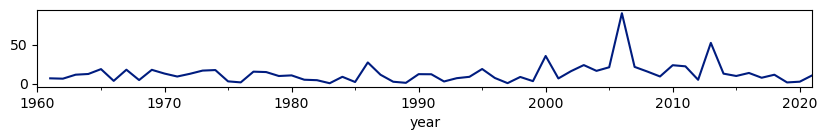

In [75]:
data["GDP_volatility"].plot()

<AxesSubplot:xlabel='year'>

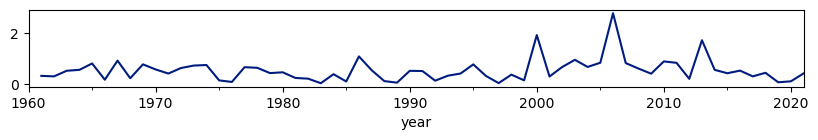

In [76]:
data["log10_GDP_volatility"].plot()

### Модель GARCH для ряда волатильности GDP

Ряд волатильности конкретно для ВВП Ганы, вообще говоря, получился стационарными и похожим на белый шум.<br>
Всё же выберем какие-нибудь p и q ручным подбором визуально по графику прогноза.

In [77]:
garch_data = pd.DataFrame(data['GDP_volatility'].loc[data.index])
# ...
garch_data.loc[train_data.index, 'GDP_volatility'] = train_data['GDP_volatility'].dropna()
display(garch_data.head())
display(garch_data.tail())

,GDP_volatility
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636


,GDP_volatility
year,
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746
2020-01-01,2.495937
2021-01-01,10.780603


In [78]:
garch_model = arch_model(
    garch_data['GDP_volatility'].dropna(),
    p=13, q=13,
    vol='GARCH',
    mean='Constant', dist='studentst')
garch_model_results = garch_model.fit(last_obs=test_data.index[0], update_freq=5)

Iteration:      5,   Func. Count:    157,   Neg. LLF: 211.25864158546435
Iteration:     10,   Func. Count:    310,   Neg. LLF: 208.1730253596526
Iteration:     15,   Func. Count:    460,   Neg. LLF: 208.17009674706662
Iteration:     20,   Func. Count:    610,   Neg. LLF: 208.10647956396429
Iteration:     25,   Func. Count:    761,   Neg. LLF: 208.01541310403937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 208.01420764423366
            Iterations: 29
            Function evaluations: 880
            Gradient evaluations: 29


In [79]:
garch_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               GDP_volatility   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -208.014
Distribution:      Standardized Student's t   AIC:                           474.028
Method:                  Maximum Likelihood   BIC:                           533.781
                                              No. Observations:                   58
Date:                      Thu, Nov 24 2022   Df Residuals:                       57
Time:                              13:51:21   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.9181      2.007      5.441  5.297e-08 [  6.985, 14.851]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         25.0806    145.801      0.172      0.863 [-2.607e+02,3.108e+02]
alpha[1]       0.0000      0.367      0.000      1.000      [ -0.720,  0.720]
alpha[2]       0.0000      0.300      0.000      1.000      [ -0.588,  0.588]
alpha[3]       0.0000      0.141      0.000      1.000      [ -0.276,  0.276]
alpha[4]       0.0156  4.509e-02      0.347      0.729   [-7.274e-02,  0.104]
alpha[5]       0.0160      0.179  8.940e-02      0.929      [ -0.334,  0.366]
alpha[6]   1.4883e-10      0.207  7.192e-10      1.000      [ -0.406,  0.406]
alpha[7]       0.3885      0.344      1.130      0.259      [ -0.285,  1.062]
alpha[8]       0.0000      0.624      0.000      1.000      [ -1.223,  1.223]
alpha[9]       0.0000      1.580      0.000      1.000      [ -3.097,  3.097]
alpha[10]      0.0000      2.747      0.000      1.000      [ -5.385,  5.385]
alpha[11]      0.0000      1.946      0.000      1.000      [ -3.815,  3.815]
alpha[12]      0.0000      1.202      0.000      1.000      [ -2.355,  2.355]
alpha[13]      0.0000      0.738      0.000      1.000      [ -1.447,  1.447]
beta[1]        0.0000      2.471      0.000      1.000      [ -4.843,  4.843]
beta[2]        0.0000      4.028      0.000      1.000      [ -7.894,  7.894]
beta[3]        0.0000      6.959      0.000      1.000      [-13.640, 13.640]
beta[4]        0.0000      5.008      0.000      1.000      [ -9.815,  9.815]
beta[5]        0.0000      2.724      0.000      1.000      [ -5.340,  5.340]
beta[6]        0.0000      2.935      0.000      1.000      [ -5.752,  5.752]
beta[7]        0.0000      6.996      0.000      1.000      [-13.712, 13.712]
beta[8]        0.0000      1.500      0.000      1.000      [ -2.939,  2.939]
beta[9]        0.0000      2.283      0.000      1.000      [ -4.475,  4.475]
beta[10]       0.2735      9.768  2.800e-02      0.978      [-18.872, 19.419]
beta[11]       0.0000      3.221      0.000      1.000      [ -6.313,  6.313]
beta[12]       0.0000      5.083      0.000      1.000      [ -9.962,  9.962]
beta[13]       0.3064      2.946      0.104      0.917      [ -5.467,  6.080]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.1402      

#### Прогноз волатильности

In [80]:
garch_model_predictions = test_data.copy()
garch_model_predictions['predictions'] = garch_model_results.forecast(reindex=True).residual_variance.loc[test_data.index]

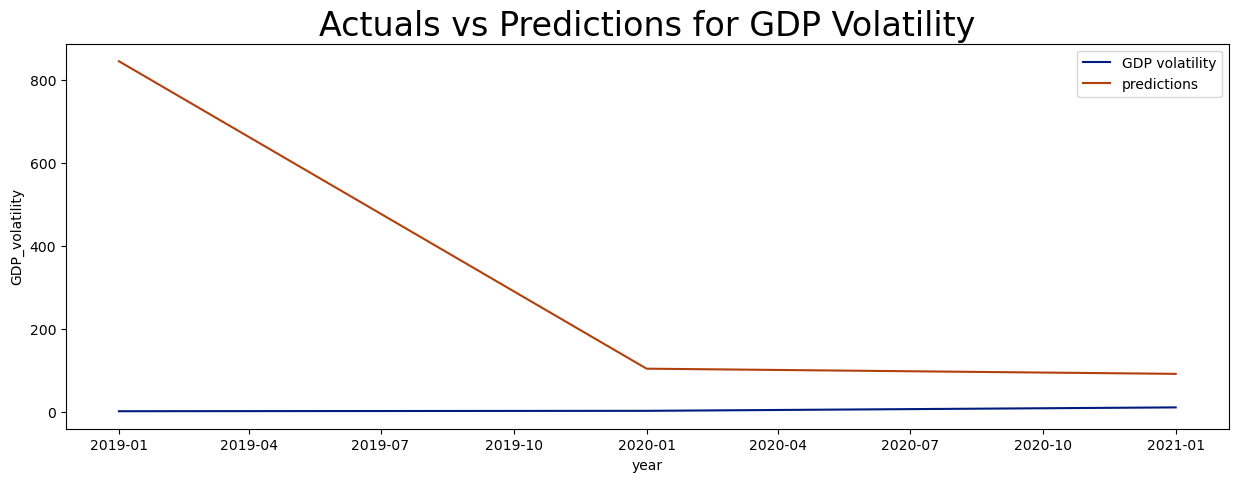

In [81]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 5)

sns.lineplot(
    data=garch_model_predictions,
    x=garch_model_predictions.index, y='GDP_volatility',
    markers=True,
    ax=ax, label='GDP volatility'
)
sns.lineplot(
    data=garch_model_predictions,
    x=garch_model_predictions.index, y='predictions',
    markers=['o'],
    ax=ax, label='predictions'
)
plt.legend()
plt.title("Actuals vs Predictions for GDP Volatility", size = 24)
plt.show()

In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(garch_model_predictions["GDP_volatility"].abs(), garch_model_predictions["predictions"]))

493.33196982012737

**Модель плохо улавливает дисперсию на тестовой выборке.**
В обучающей выборке нет достаточного количества примеров убывания и возрастания дисперсии, которые бы встречались в (такой малой) тестовой выборке.<br>
**И в целом, временной ряд ВВП конкретно страны Гана выглядит достаточно специфичным примером для вычисления волатильности, как это можно видеть из её диаграмм частичной автокорреляции.**

In [83]:
data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000,NaN,NaN
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140,6.789413,0.314003
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937,6.357759,0.293720
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150,11.448835,0.515015
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510,12.363636,0.551017


#### Модель GARCH с линейной регрессией

<AxesSubplot:>

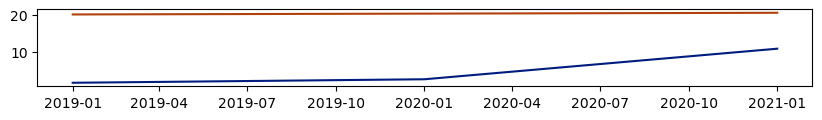

In [84]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data['GDP_volatility'].shape[0]))[:train_data.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['GDP_volatility'].shape[0]))[train_data.shape[0]:].fillna(0)
y_train = train_data['GDP_volatility'].fillna(0)
y_test = test_data['GDP_volatility'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
lr_plot = plt.plot(pd.Series(lr_predict, index=y_test.index))
sns.lineplot()

### Модель GARCH для логарифма ряда волатильности GDP

Ряд волатильности логарифма ВВП Ганы, вообще говоря, получился стационарными и похожим на белый шум.<br>
Всё же выберем какие-нибудь p и q ручным подбором визуально по графику прогноза.

In [85]:
log10_garch_data = pd.DataFrame(data['log10_GDP_volatility'].loc[data.index])
# ...
log10_garch_data.loc[train_data.index, 'log10_GDP_volatility'] = train_data['log10_GDP_volatility'].dropna()
log10_garch_data.head()

,log10_GDP_volatility
year,
1960-01-01,NaN
1961-01-01,0.314003
1962-01-01,0.293720
1963-01-01,0.515015
1964-01-01,0.551017


In [86]:
log10_garch_model = arch_model(log10_garch_data['log10_GDP_volatility'].dropna(), p=3, q=12, vol='GARCH')
log10_garch_model_results = log10_garch_model.fit(last_obs=test_data.index[0], update_freq=5)

Iteration:      5,   Func. Count:     98,   Neg. LLF: 33.912212215926715
Iteration:     10,   Func. Count:    188,   Neg. LLF: 52.282643665570006
Iteration:     15,   Func. Count:    283,   Neg. LLF: 27.178687466156564
Iteration:     20,   Func. Count:    373,   Neg. LLF: 26.548782479900055
Iteration:     25,   Func. Count:    471,   Neg. LLF: 26.675169978224737
Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.542769815869484
            Iterations: 29
            Function evaluations: 527
            Gradient evaluations: 28


In [87]:
log10_garch_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GARCH Model Results                       
================================================================================
Dep. Variable:     log10_GDP_volatility   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:               -26.5428
Distribution:                    Normal   AIC:                           87.0855
Method:              Maximum Likelihood   BIC:                           122.113
                                          No. Observations:                   58
Date:                  Thu, Nov 24 2022   Df Residuals:                       57
Time:                          13:51:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4822  4.657e-02     10.354  4.008e-25 [  0.391,  0.573]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0222  5.006e-02      0.443      0.658   [-7.595e-02,  0.120]
alpha[1]       0.0000  9.890e-02      0.000      1.000      [ -0.194,  0.194]
alpha[2]       0.0000  4.752e-02      0.000      1.000 [-9.314e-02,9.314e-02]
alpha[3]       0.6214      0.300      2.070  3.846e-02    [3.300e-02,  1.210]
beta[1]        0.0000  7.815e-02      0.000      1.000      [ -0.153,  0.153]
beta[2]        0.0000  3.651e-02      0.000      1.000 [-7.156e-02,7.156e-02]
beta[3]        0.2144      0.142      1.509      0.131   [-6.407e-02,  0.493]
beta[4]        0.0861  9.702e-02      0.888      0.375      [ -0.104,  0.276]
beta[5]        0.0000      0.137      0.000      1.000      [ -0.269,  0.269]
beta[6]        0.0000      0.155      0.000      1.000      [ -0.304,  0.304]
beta[7]        0.0000      0.212      0.000      1.000      [ -0.415,  0.415]
beta[8]        0.0000  9.605e-02      0.000      1.000      [ -0.188,  0.188]
beta[9]        0.0000  4.666e-02      0.000      1.000 [-9.145e-02,9.145e-02]
beta[10]       0.0000      0.234      0.000      1.000      [ -0.458,  0.458]
beta[11]       0.0781      0.358      0.218      0.827      [ -0.624,  0.780]
beta[12]       0.0000      0.315      0.000      1.000      [ -0.618,  0.618]
=============================================================================

Covariance estimator: robust
"""

#### Прогноз волатильности

In [88]:
log10_garch_model_predictions = test_data.copy()
log10_garch_model_predictions['predictions'] = log10_garch_model_results.forecast(
    reindex=True).residual_variance.loc[test_data.index]

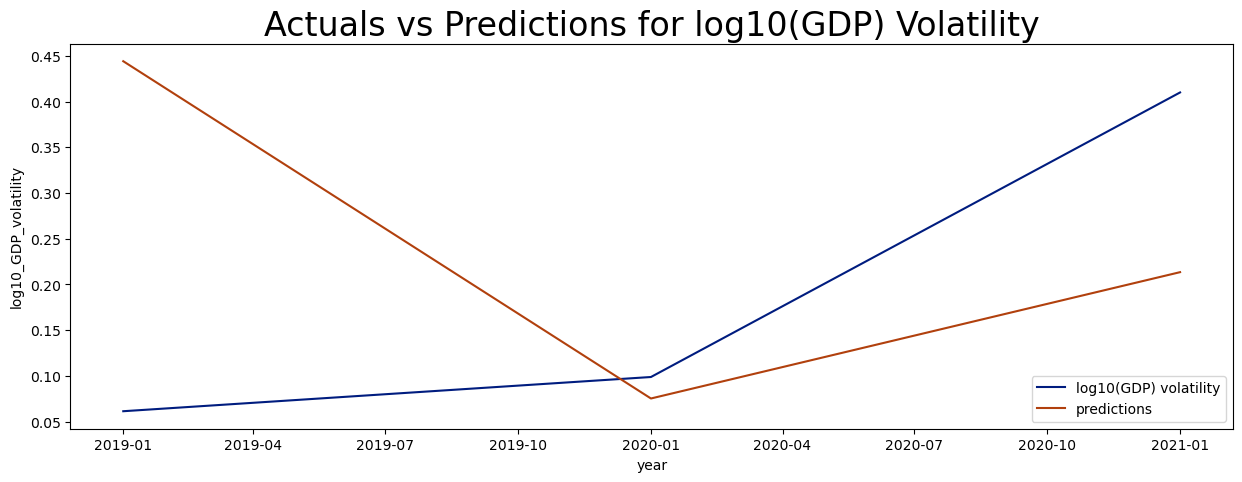

In [89]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 5)

sns.lineplot(
    data=log10_garch_model_predictions,
    x=log10_garch_model_predictions.index, y='log10_GDP_volatility',
    markers=True,
    ax=ax, label='log10(GDP) volatility'
)
sns.lineplot(
    data=log10_garch_model_predictions,
    x=log10_garch_model_predictions.index, y='predictions',
    ax=ax, label='predictions'
)
plt.legend()
plt.title("Actuals vs Predictions for log10(GDP) Volatility", size = 24)
plt.show()

**Модель плохо улавливает дисперсию на тестовой выборке.**
В обучающей выборке нет достаточного количества примеров убывания и возрастания дисперсии, которые бы встречались в (такой малой) тестовой выборке.<br>
**И в целом, временной ряд ВВП конкретно страны Гана выглядит достаточно специфичным примером для вычисления волатильности, как это можно видеть из её диаграмм частичной автокорреляции.**

**Там не менее, работа с волатильностью логарифма ВВП метрикам модели и по графику прогноза выглядит более перспективной.**

### ARIMA + GARCH

Просто попытка совместить ARIMA и GARCH. На самом деле надо было бы перебирать гиперпараметры ARIMA(p d q) и GARCH(p', q').

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1301.7607632754841
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1301.5619622139611
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1301.5619622139418
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


array([2.12972350e+19, 2.15211552e+19, 2.17450753e+19])

,arima_garch_predictions,GDP
year,,
2019-01-01,7.242848e+10,6.833754e+10
2020-01-01,7.713394e+10,7.004320e+10
2021-01-01,7.975709e+10,7.759428e+10


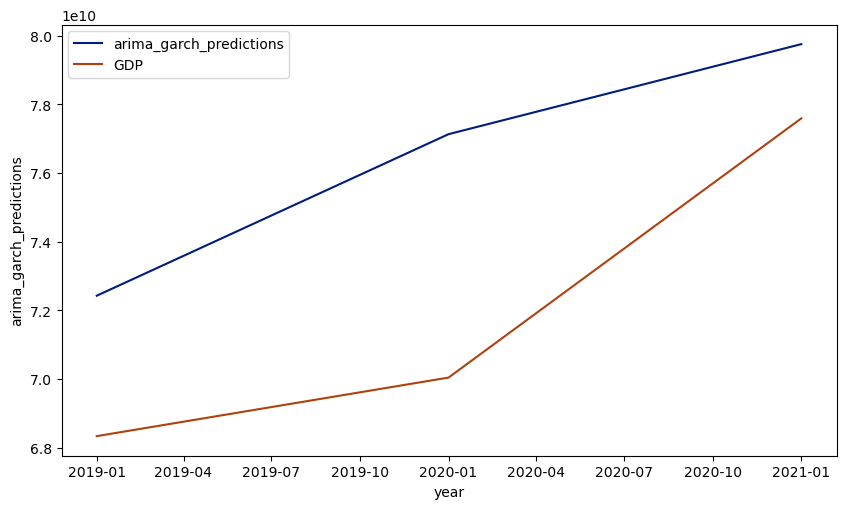

In [90]:
arima_model = ARIMA(train_data['GDP'],
                   order=(1, 2, 3), seasonal_order=(0, 0, 0, 0),
                   enforce_stationarity=True, enforce_invertibility=True,
                   concentrate_scale=False)
arima_model_fit = arima_model.fit()
arima_residuals = arima_model_fit.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch_model = arch_model(
    arima_residuals,
    p=1, q=1,
    vol='GARCH',
    mean='Constant', dist='studentst')
garch_model_results = garch_model.fit(last_obs=train_data.index[-1], update_freq=5);

# Use ARIMA to predict mu
arima_predicted_data = make_predictions(
    arima_model_fit, test_data,
    original_data=data, target_column='GDP',
    significance_level=0.05
)
# display(arima_predicted_data.loc[test_data.index])
arima_predicted_data_mu = arima_predicted_data['model_predictions'].loc[test_data.index]

# Use GARCH to predict the residual
garch_forecast = garch_model_results.forecast(horizon=len(test_data) + 0)
predicted_data_et = (garch_forecast.residual_variance.iloc[-1]).values[0:]
display(predicted_data_et)

# Combine both models' output.
# Надо уточнить формулу. residual_variance явно квадратичные в GARCH.
arima_garch_prediction_values = arima_predicted_data_mu.values + np.sqrt(predicted_data_et)
arima_garch_prediction_values

arima_garch_data = pd.DataFrame({'arima_garch_predictions': arima_garch_prediction_values, 'GDP': test_data['GDP'].values})
arima_garch_data = arima_garch_data.set_index(test_data.index)
display(arima_garch_data)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5.6)
sns.lineplot(data=arima_garch_data, x=arima_garch_data.index, y='arima_garch_predictions', label='arima_garch_predictions')
sns.lineplot(data=arima_garch_data, x=arima_garch_data.index, y='GDP', label='GDP')
plt.legend()
plt.show()


##### Логарифм

Iteration:      5,   Func. Count:     39,   Neg. LLF: -17.942535982486753
Iteration:     10,   Func. Count:     75,   Neg. LLF: 368.5823196759101
Iteration:     15,   Func. Count:    110,   Neg. LLF: 315.3458897629263
Iteration:     20,   Func. Count:    145,   Neg. LLF: -43.30836217322948
Iteration:     25,   Func. Count:    180,   Neg. LLF: -57.971818138567315
Iteration:     30,   Func. Count:    215,   Neg. LLF: -60.75760256104219
Iteration:     35,   Func. Count:    245,   Neg. LLF: -62.62078354210772
Iteration:     40,   Func. Count:    275,   Neg. LLF: -62.90060996057712
Iteration:     45,   Func. Count:    305,   Neg. LLF: -62.91876142447859
Iteration:     50,   Func. Count:    335,   Neg. LLF: 28.514893262617772
Optimization terminated successfully    (Exit mode 0)
            Current function value: -62.92616995733589
            Iterations: 53
            Function evaluations: 350
            Gradient evaluations: 51


array([0.0090008, 0.0179663, 0.0269318])

,arima_garch_predictions_log10,log10_GDP
year,,
2019-01-01,10.954072,10.834659
2020-01-01,11.024583,10.845366
2021-01-01,11.085578,10.889830


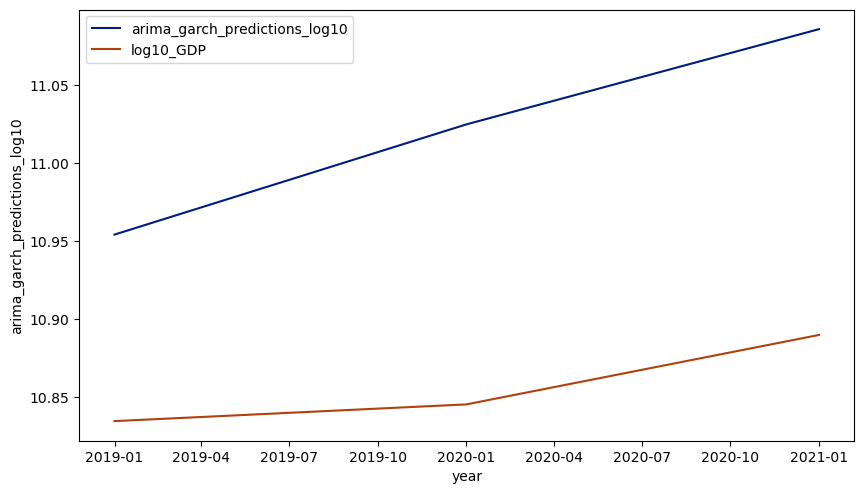

In [91]:
arima_model_log10 = ARIMA(train_data['log10_GDP'],
                   order=(1, 2, 3), seasonal_order=(0, 0, 0, 0),
                   enforce_stationarity=True, enforce_invertibility=True,
                   concentrate_scale=False)
arima_model_fit_log10 = arima_model_log10.fit()
arima_residuals_log10 = arima_model_fit_log10.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch_model_log10 = arch_model(
    arima_residuals_log10,
    p=1, q=1,
    vol='GARCH',
    mean='Constant', dist='studentst')
garch_model_results_log10 = garch_model_log10.fit(last_obs=train_data.index[-1], update_freq=5);

# Use ARIMA to predict mu
arima_predicted_data_log10 = make_predictions(
    arima_model_fit_log10, test_data,
    original_data=data, target_column='log10_GDP',
    significance_level=0.05
)
# display(arima_predicted_data.loc[test_data.index])
arima_predicted_data_mu_log10 = arima_predicted_data_log10['model_predictions'].loc[test_data.index]

# Use GARCH to predict the residual
garch_forecast_log10 = garch_model_results_log10.forecast(horizon=len(test_data) + 0)
predicted_data_et_log10 = (garch_forecast_log10.residual_variance.iloc[-1]).values[0:]
display(predicted_data_et_log10)

# Combine both models' output.
# Надо уточнить формулу. residual_variance явно квадратичные в GARCH.
arima_garch_prediction_values_log10 = arima_predicted_data_mu_log10.values + np.sqrt(predicted_data_et_log10) # Надо уточнить формулу
arima_garch_prediction_values_log10

arima_garch_data_log10 = pd.DataFrame({'arima_garch_predictions_log10': arima_garch_prediction_values_log10, 'log10_GDP': test_data['log10_GDP'].values})
arima_garch_data_log10 = arima_garch_data_log10.set_index(test_data.index)
display(arima_garch_data_log10)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5.6)
sns.lineplot(data=arima_garch_data_log10, x=arima_garch_data_log10.index, y='arima_garch_predictions_log10', label='arima_garch_predictions_log10')
sns.lineplot(data=arima_garch_data_log10, x=arima_garch_data_log10.index, y='log10_GDP', label='log10_GDP')
plt.legend()
plt.show()


## Prophet

In [92]:
data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000,NaN,NaN
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140,6.789413,0.314003
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937,6.357759,0.293720
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150,11.448835,0.515015
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510,12.363636,0.551017


### Изначальный ряд

In [93]:
data_prophet = data[['GDP']].reset_index(level=0).rename(columns={'year': 'ds', 'GDP': 'y'})
data_prophet.head()

,ds,y
0,1960-01-01,1.217087e+09
1,1961-01-01,1.299720e+09
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
4,1964-01-01,1.731092e+09


In [94]:
train_data_prophet = data_prophet[data_prophet['ds'] <= '2018-12-31']
test_data_prophet = data_prophet[data_prophet['ds'] >= '2019-01-01']

display((train_data_prophet.shape, test_data_prophet.shape))
display(train_data_prophet.tail())
display(test_data_prophet.head())

((59, 2), (3, 2))

,ds,y
54,2014-01-01,5.478285e+10
55,2015-01-01,4.940657e+10
56,2016-01-01,5.616517e+10
57,2017-01-01,6.040638e+10
58,2018-01-01,6.729928e+10


,ds,y
59,2019-01-01,6.833754e+10
60,2020-01-01,7.004320e+10
61,2021-01-01,7.759428e+10


In [95]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

13:51:24 - cmdstanpy - INFO - Chain [1] start processing
13:51:24 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
future_dates = prophet_model.make_future_dataframe(periods=3, freq='Y')
future_dates['ds'] = future_dates['ds'] + pd.Timedelta(days=1)
future_dates.tail(3)

,ds
59,2019-01-01
60,2020-01-01
61,2021-01-01


In [97]:
forecast_data = prophet_model.predict(future_dates)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
57,2017-01-02,3.863885e+10,2.331992e+10,5.252882e+10
58,2018-01-02,3.875839e+10,2.377902e+10,5.414957e+10
59,2019-01-01,3.667671e+10,2.124233e+10,5.165096e+10
60,2020-01-01,3.701026e+10,2.267730e+10,5.194329e+10
61,2021-01-01,3.932247e+10,2.509011e+10,5.370492e+10


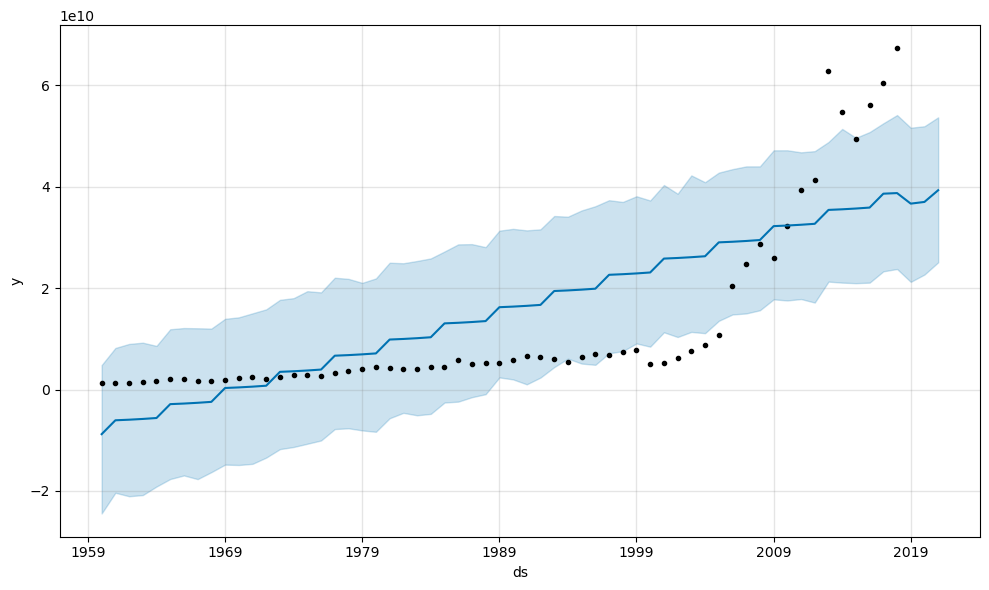

In [98]:
fig = prophet_model.plot(forecast_data)

Модель Prophet больше ориентирована на сезонные явления с периодами в дни и недели. Она не подходит для прогнозов на длительные периоды таких финансовых временных рядов, как ВВП.

## ARIMAX - добавление экзогенных факторов 

### Инфляция

Имеются данные о потребительской инфляции в Гане за период 1965-2021 г.г.

In [99]:
data.head()

,GDP,log10_GDP,GDP_pct_change,log10_GDP_pct_change,GDP_volatility,log10_GDP_volatility
year,,,,,,
1960-01-01,1.217087e+09,9.085322,0.000000,0.000000,NaN,NaN
1961-01-01,1.299720e+09,9.113850,0.067894,0.003140,6.789413,0.314003
1962-01-01,1.382353e+09,9.140619,0.063578,0.002937,6.357759,0.293720
1963-01-01,1.540616e+09,9.187694,0.114488,0.005150,11.448835,0.515015
1964-01-01,1.731092e+09,9.238320,0.123636,0.005510,12.363636,0.551017


In [100]:
inflation_data = pd.read_csv('./data/inflation/inflation_Ghana_1965-2021.csv', parse_dates=['year'], index_col=['year'])
display(inflation_data.head(3))
display(inflation_data.tail(3))

,inflation
year,
1965-01-01,26.444785
1966-01-01,13.237885
1967-01-01,-8.422486


,inflation
year,
2019-01-01,7.143640
2020-01-01,9.887290
2021-01-01,9.971089


In [101]:
data_with_inflation = data[['GDP', 'log10_GDP']]
data_with_inflation = data_with_inflation.loc['1965-01-01':]
data_with_inflation = pd.concat([data_with_inflation, inflation_data], axis=1) # ignore_index=True
data_with_inflation.head()

,GDP,log10_GDP,inflation
year,,,
1965-01-01,2.053221e+09,9.312436,26.444785
1966-01-01,2.126050e+09,9.327574,13.237885
1967-01-01,1.746806e+09,9.242245,-8.422486
1968-01-01,1.666910e+09,9.221912,7.894737
1969-01-01,1.962051e+09,9.292710,7.317073


In [102]:
train_data_with_inflation = data_with_inflation.loc[:'2018-12-31']
test_data_with_inflation = data_with_inflation['2019-01-01':]

display((train_data_with_inflation.shape, test_data_with_inflation.shape))
display(train_data_with_inflation.tail())
display(test_data_with_inflation.head())

((54, 3), (3, 3))

,GDP,log10_GDP,inflation
year,,,
2014-01-01,5.478285e+10,10.738645,15.489616
2015-01-01,4.940657e+10,10.693785,17.149970
2016-01-01,5.616517e+10,10.749467,17.454635
2017-01-01,6.040638e+10,10.781083,12.371922
2018-01-01,6.729928e+10,10.828010,7.808765


,GDP,log10_GDP,inflation
year,,,
2019-01-01,6.833754e+10,10.834659,7.143640
2020-01-01,7.004320e+10,10.845366,9.887290
2021-01-01,7.759428e+10,10.889830,9.971089


#### Оригинальный ряд

In [103]:
arimax_model_inflation = train_arima_model(
    train_data_with_inflation['GDP'],
    order=(1, 2, 3), seasonal_order=(0, 0, 0, 0),
    exog=train_data_with_inflation[['inflation']]
)

arimax_model_inflation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   54
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1220.832
Date:                Thu, 24 Nov 2022   AIC                           2453.664
Time:                        13:51:25   BIC                           2465.372
Sample:                    01-01-1965   HQIC                          2458.153
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inflation  -3.207e+06   2.84e-09  -1.13e+15      0.000   -3.21e+06   -3.21e+06
ar.L1         -0.5577      0.260     -2.145      0.032      -1.067      -0.048
ma.L1         -0.4373      0.362     -1.208      0.227      -1.147       0.272
ma.L2         -0.8066      0.301     -2.683      0.007      -1.396      -0.217
ma.L3          0.5145      0.146      3.525      0.000       0.228       0.801
sigma2      2.086e+19   5.42e-20   3.85e+38      0.000    2.09e+19    2.09e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               142.96
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             185.18   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+53. Standard errors may be unstable.
"""

In [104]:
predicted_data_with_inflation = make_predictions(
    arimax_model_inflation, test_data_with_inflation,
    original_data=data_with_inflation, target_column='GDP',
    significance_level=0.05,
    exog=test_data_with_inflation['inflation']
)

predicted_data_with_inflation.loc[test_data_with_inflation.index]

,model_predictions,GDP,model_predictions_lower,model_predictions_upper
year,,,,
2019-01-01,6.782118e+10,6.833754e+10,5.886593e+10,7.677643e+10
2020-01-01,7.248406e+10,7.004320e+10,5.979166e+10,8.517646e+10
2021-01-01,7.508479e+10,7.759428e+10,6.068979e+10,8.947980e+10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


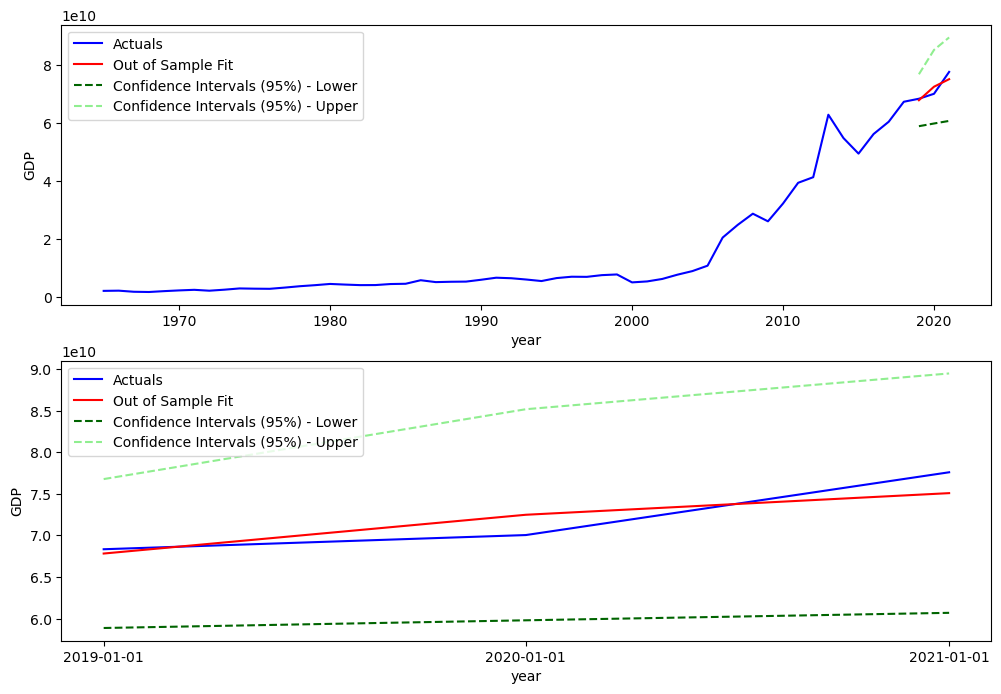

In [105]:
plot_predictions(
    predicted_data_with_inflation, test_data_with_inflation,
    target_column='GDP',
    predictions_column='model_predictions',
    predictions_column_lower='model_predictions_lower',
    predictions_column_upper='model_predictions_upper',
    size_inches=(12, 8)
)

ARIMAX с инфляцией по сравнению с ARIMA даёт практически такие же прогнозы, но у него поменьше AIC и повыше Log Likelihood.

#### Ряд логарифма ВВП

In [106]:
arimax_model_inflation = train_arima_model(
    train_data_with_inflation['log10_GDP'],
    order=(4, 1, 5), seasonal_order=(0, 0, 0, 0),
    exog=train_data_with_inflation['inflation']
)

arimax_model_inflation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log10_GDP   No. Observations:                   54
Model:                 ARIMA(4, 1, 5)   Log Likelihood                  69.714
Date:                Thu, 24 Nov 2022   AIC                           -117.427
Time:                        13:51:26   BIC                            -95.754
Sample:                    01-01-1965   HQIC                          -109.093
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inflation     -0.0002      0.000     -0.604      0.546      -0.001       0.000
ar.L1         -0.7372      1.295     -0.569      0.569      -3.274       1.800
ar.L2          0.2415      0.997      0.242      0.809      -1.712       2.195
ar.L3          0.7377      0.886      0.832      0.405      -0.999       2.475
ar.L4          0.3745      0.777      0.482      0.630      -1.147       1.896
ma.L1          1.0598      1.366      0.776      0.438      -1.618       3.738
ma.L2         -0.0292      1.537     -0.019      0.985      -3.043       2.984
ma.L3         -0.7010      0.672     -1.044      0.296      -2.017       0.615
ma.L4         -0.4232      0.980     -0.432      0.666      -2.343       1.497
ma.L5          0.1166      0.380      0.307      0.759      -0.628       0.862
sigma2         0.0041      0.001      3.236      0.001       0.002       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 9.00
Prob(Q):                              0.66   Prob(JB):                         0.01
Heteroskedasticity (H):               3.25   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
predicted_data_with_inflation = make_predictions(
    arimax_model_inflation, test_data_with_inflation,
    original_data=data_with_inflation, target_column='log10_GDP',
    significance_level=0.05,
    exog=test_data_with_inflation['inflation']
)

predicted_data_with_inflation.loc[test_data_with_inflation.index]

,model_predictions,log10_GDP,model_predictions_lower,model_predictions_upper
year,,,,
2019-01-01,10.832012,10.834659,10.706035,10.957989
2020-01-01,10.869706,10.845366,10.660850,11.078562
2021-01-01,10.880429,10.889830,10.615257,11.145602


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


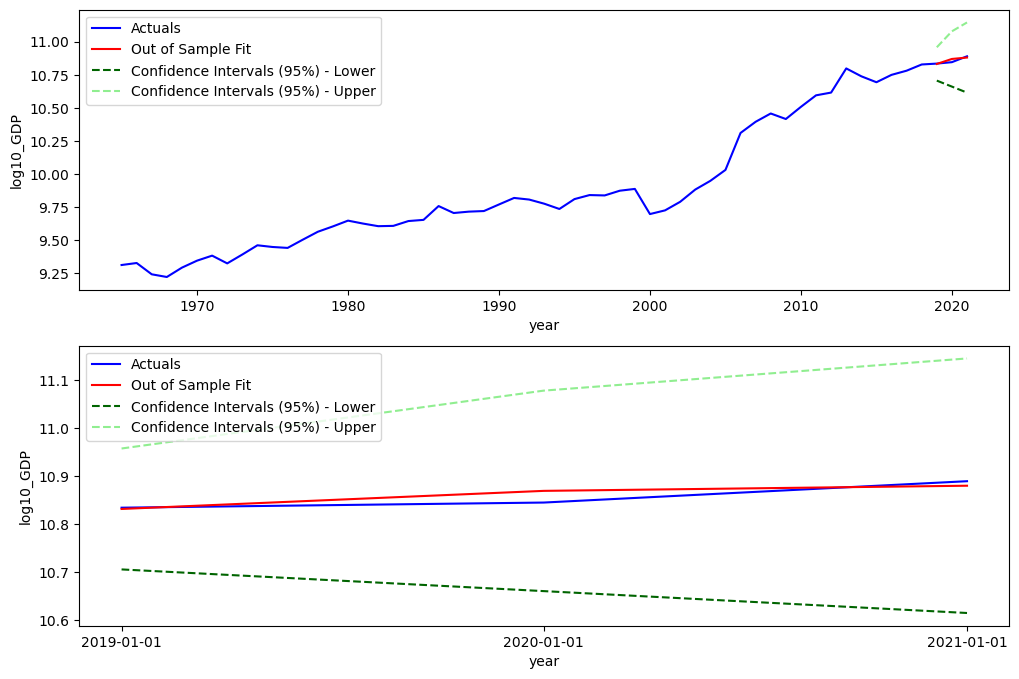

In [108]:
plot_predictions(
    predicted_data_with_inflation, test_data_with_inflation,
    target_column='log10_GDP',
    predictions_column='model_predictions',
    predictions_column_lower='model_predictions_lower',
    predictions_column_upper='model_predictions_upper',
    size_inches=(12, 8)
)

- ARIMAX+log10 - поменьше гетероскедатичность, чем просто у ARIMA+log10.
- Меньше AIC.
- <span style="color: darkred">Меньше Log Likelihood</span>